# Домашнее задание № 9

In [1]:
!pip install rusenttokenize --q
!pip install tokenizers --q

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [2]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

## Подготовка данных

In [3]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

In [4]:
data.head()

text           topic
0  Россия должна сотрудничать с Всемирным антидоп...           Спорт
1  Уголовный суд Кувейта 28 июня освободил под за...             Мир
2  Французский журнал Charlie Hebdo опубликовал н...  Интернет и СМИ
3  В Петербурге в доме № 53 по улице Лени Голиков...          Россия
4  В московском аэропорту "Домодедово" задержан г...          Россия

### Токенизация

In [5]:
# не понимаю, почему появляется предупреждение, посмотрела, вроде всё нормально разбивается по предложениям...
from tqdm import tqdm

sentences = []
for text in tqdm(data.text.values):
  sentences.extend(ru_sent_tokenize(text))

100%|██████████| 44356/44356 [00:39<00:00, 1111.72it/s]


In [6]:
len(sentences)

489727

In [7]:
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

In [8]:
sentences = open('corpus.txt').read().splitlines()

### Обучение токенизатора

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

In [10]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')

tokenizer.train(files=["corpus.txt"], trainer=trainer)
tokenizer.save('tokenizer')
tokenizer = Tokenizer.from_file("tokenizer")

tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()

In [11]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

In [12]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

### Токенизация и создание датасета

In [13]:
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        x = self.X[index][:-1]
        y = self.X[index][1:]

        mask = x!=PAD_IDX

        return x, y, mask

Разделение на обучающую и тестовую выборки

In [14]:
n = int(0.9*len(sentences))
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [15]:
MAX_LEN = 64

In [16]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [17]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

### Обучение

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
block_size = MAX_LEN
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [20]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs, attn_weights = zip(*[h(x, mask) for h in self.heads])
        out = torch.cat(head_outputs, dim=-1)
        out = self.dropout(self.proj(out))
        return out, attn_weights

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        x, mask, all_attn_outputs = inp
        out, attention = self.sa(self.ln1(x), mask)
        x = x + out
        x = x + self.ffwd(self.ln2(x))
        all_attn_outputs.extend(attention)
        return (x, mask, all_attn_outputs)

In [54]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.last_attentions = None

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, self.last_attentions = self.blocks((x, mask, [])) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        print(logits.shape)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [55]:
model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Подготовка текста для визуализации внимания

In [43]:
text_for_attn, y, mask = val_set[0]

tokens = []
for i in range(len(text_for_attn.tolist())):
  if mask[i]:
    tokens.append(tokenizer.id_to_token(text_for_attn.tolist()[i]))
print(tokens)

['[BOS]', 'Однако</w>', 'качество</w>', 'и</w>', 'коэффициен', 'т</w>', '«</w>', 'полез', 'ности</w>', '»</w>', 'такой</w>', 'работы</w>', 'поставили</w>', 'РФ</w>', 'на</w>', '9</w>', '-</w>', 'е</w>', 'место</w>', 'с</w>', 'конца</w>', '.</w>', '[EOS]']


In [45]:
text_for_attn.unsqueeze(0).shape

torch.Size([1, 63])

In [40]:
text_for_attn

tensor([    1,  1619, 13197,   397, 20850,   391,   522, 10658,   883,   506,
         3813,  2139, 13860,  1417,   691,   440,   534,   392,  1598,   419,
         3493,   434,     2,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])

In [46]:
text_for_attn = text_for_attn.unsqueeze(0).to(device)
y = y.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)

In [26]:
text_len = mask.sum()

### Обучение

In [27]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [51]:
train_losses = []
eval_losses = []
all_text_attns = []

for i in range(15):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))
    model.eval()
    with torch.no_grad():
      logits, loss = model(text_for_attn, y, mask)
      attns = [
        attn[:, :text_len, :text_len].squeeze().detach().cpu().numpy()
        for attn in model.last_attentions
    ]
      all_text_attns.append(attns)


0
Loss: 8.551983833312988
Loss: 8.147627830505371
Loss: 7.9537882804870605
Loss: 7.815970420837402
Loss: 7.701615333557129
Loss: 7.598789215087891
Loss: 7.503853797912598
Loss: 7.416179180145264
Loss: 7.333770275115967
Loss: 7.257687568664551
Loss: 7.184816360473633
Loss: 7.117188453674316
Loss: 7.054090976715088
Loss: 6.994582653045654
Loss: 6.938835144042969
Loss: 6.886646747589111
Loss: 6.836915016174316
Loss: 6.790000915527344
Loss: 6.746067047119141
Loss: 6.703757286071777
Loss: 6.663493633270264
Loss: 6.624613285064697
Eval -  5.747759819030762
В соваркие руснице расхобостью в выра- 2007 году упал на чемпионате мира 5 декабря
Верховная Рада выступает итальянской преступления на среду в 2005 году высота введения Америки
В то же время в Буказе , получать расследование протесты Бекфом досрочно уже номинилов , многие назвали государственные дом все - таки к банкротству и " предназнаокрестных раз - велоаппарата
1
Loss: 5.728679656982422
Loss: 5.711028575897217
Loss: 5.695104122161865


In [52]:
text_for_attn.shape

torch.Size([1, 63])

Epoch 0:


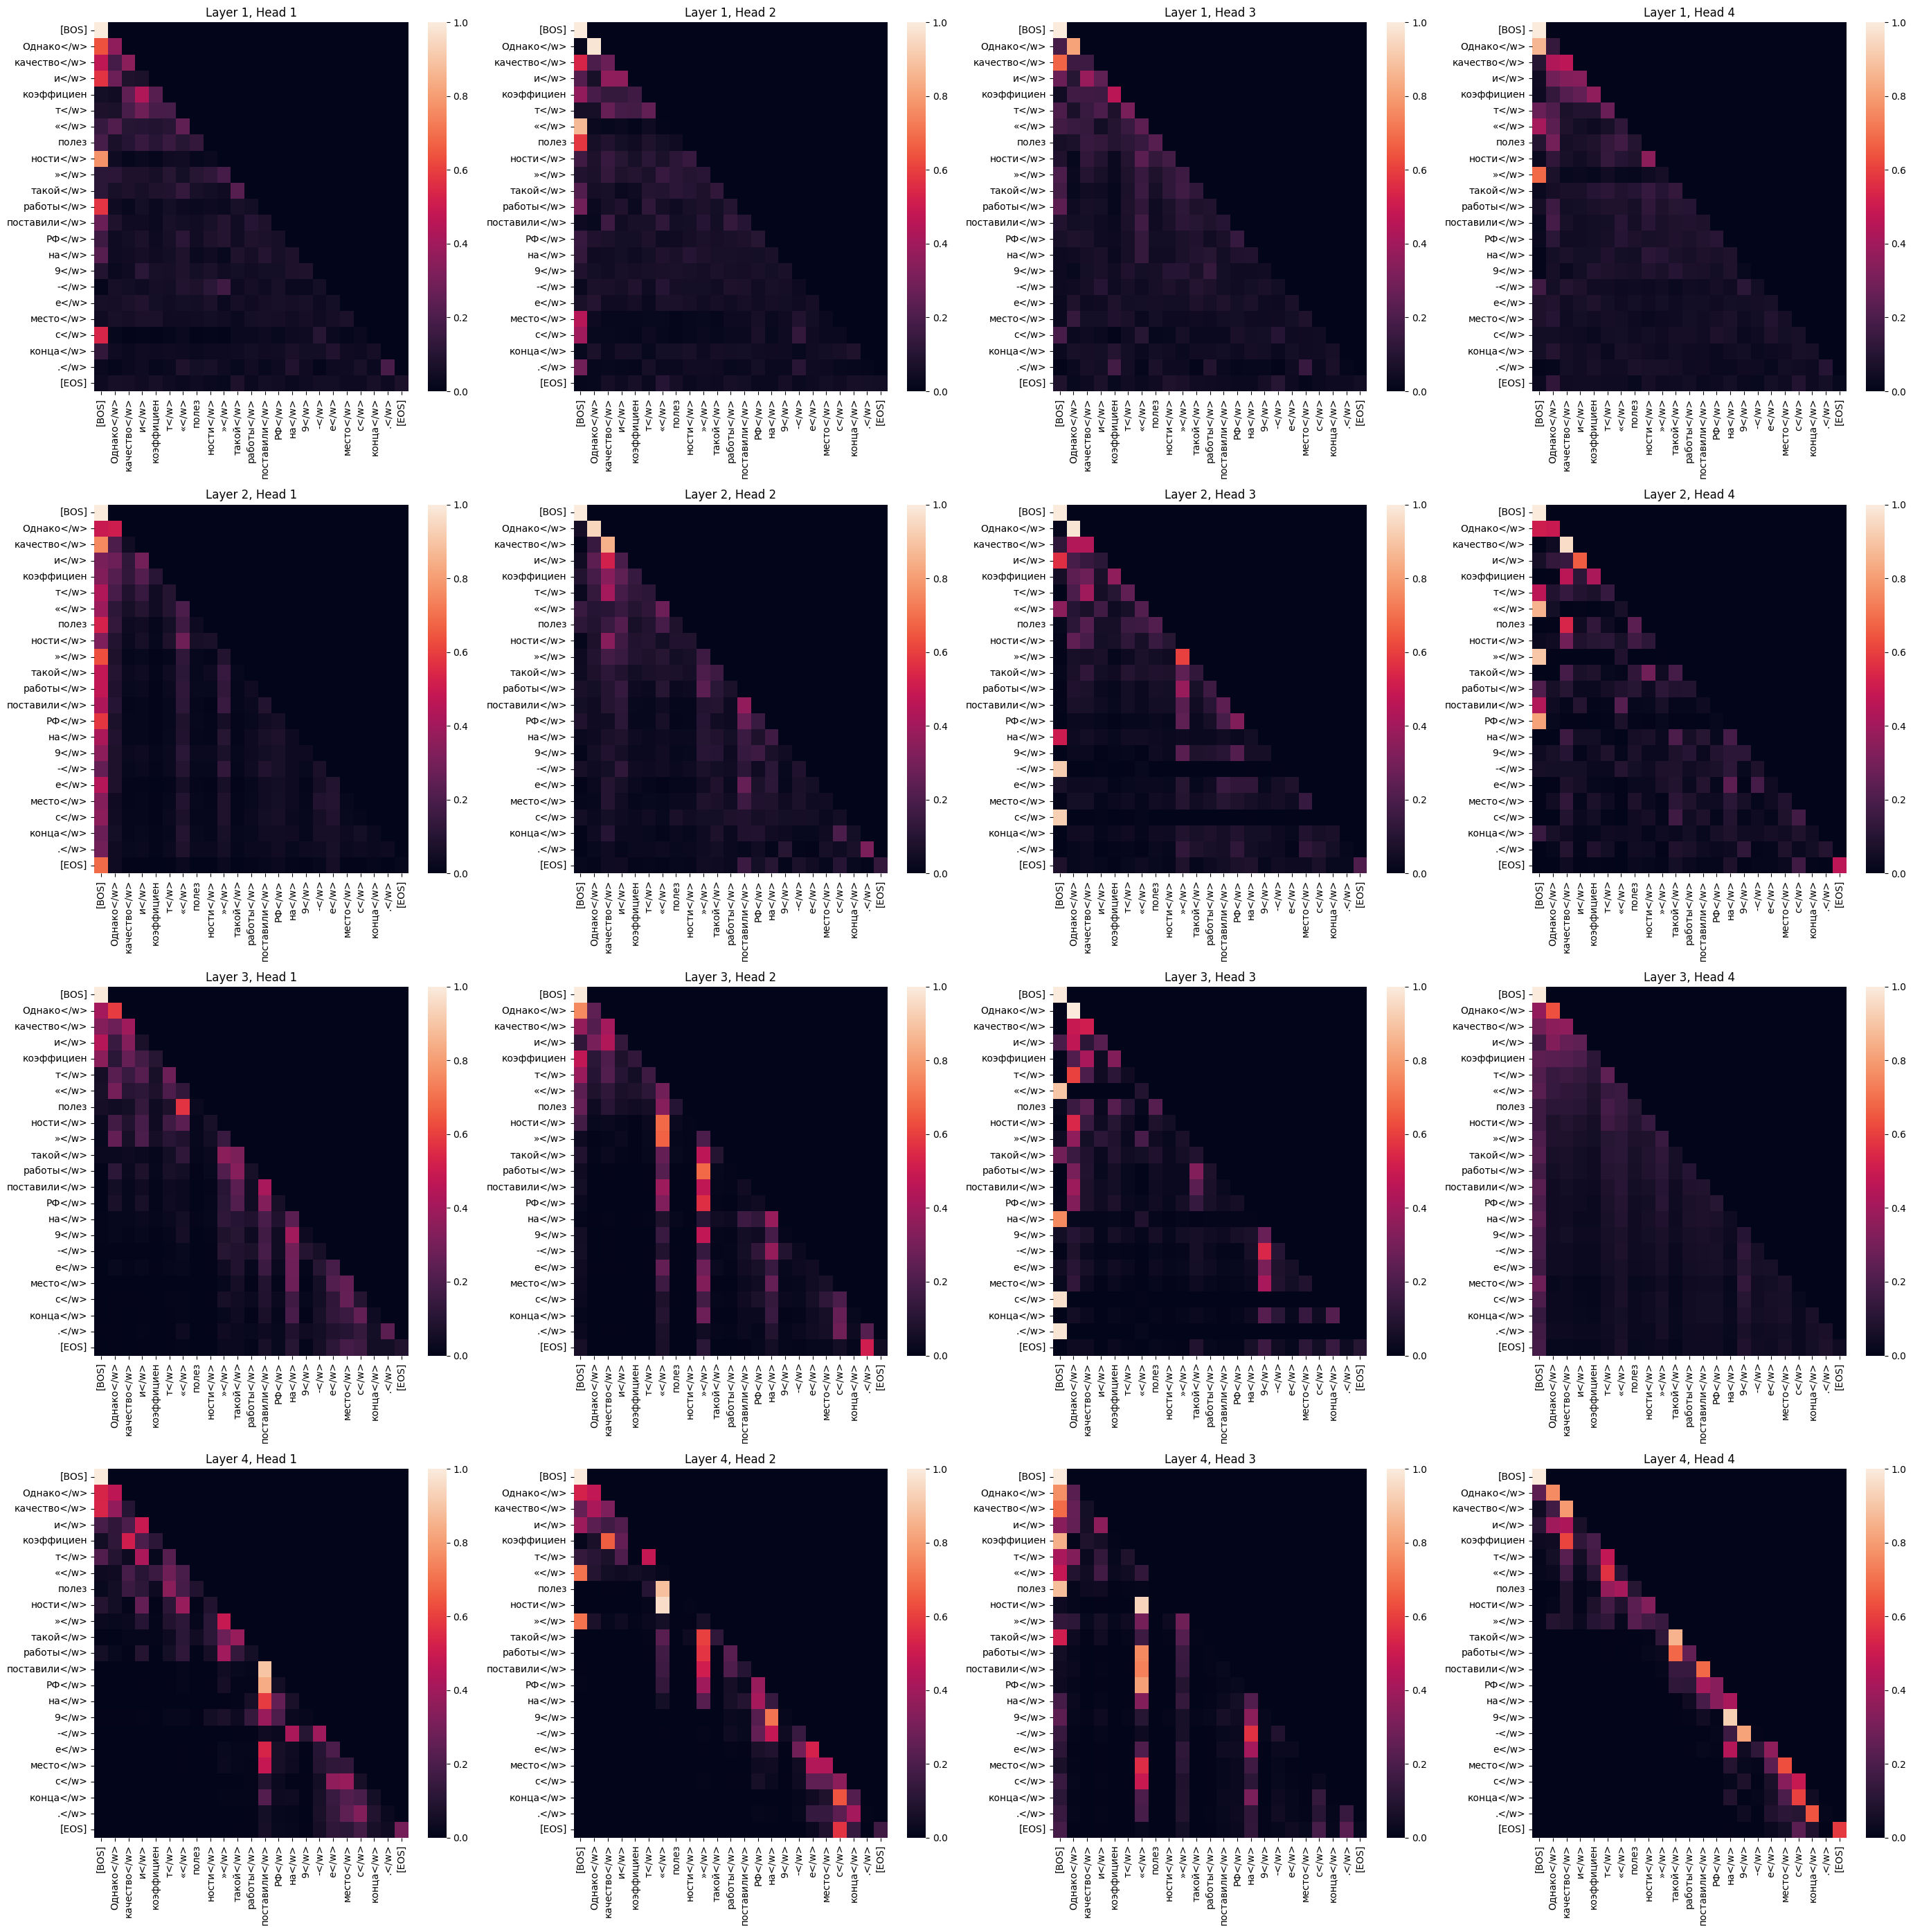

Epoch 1:


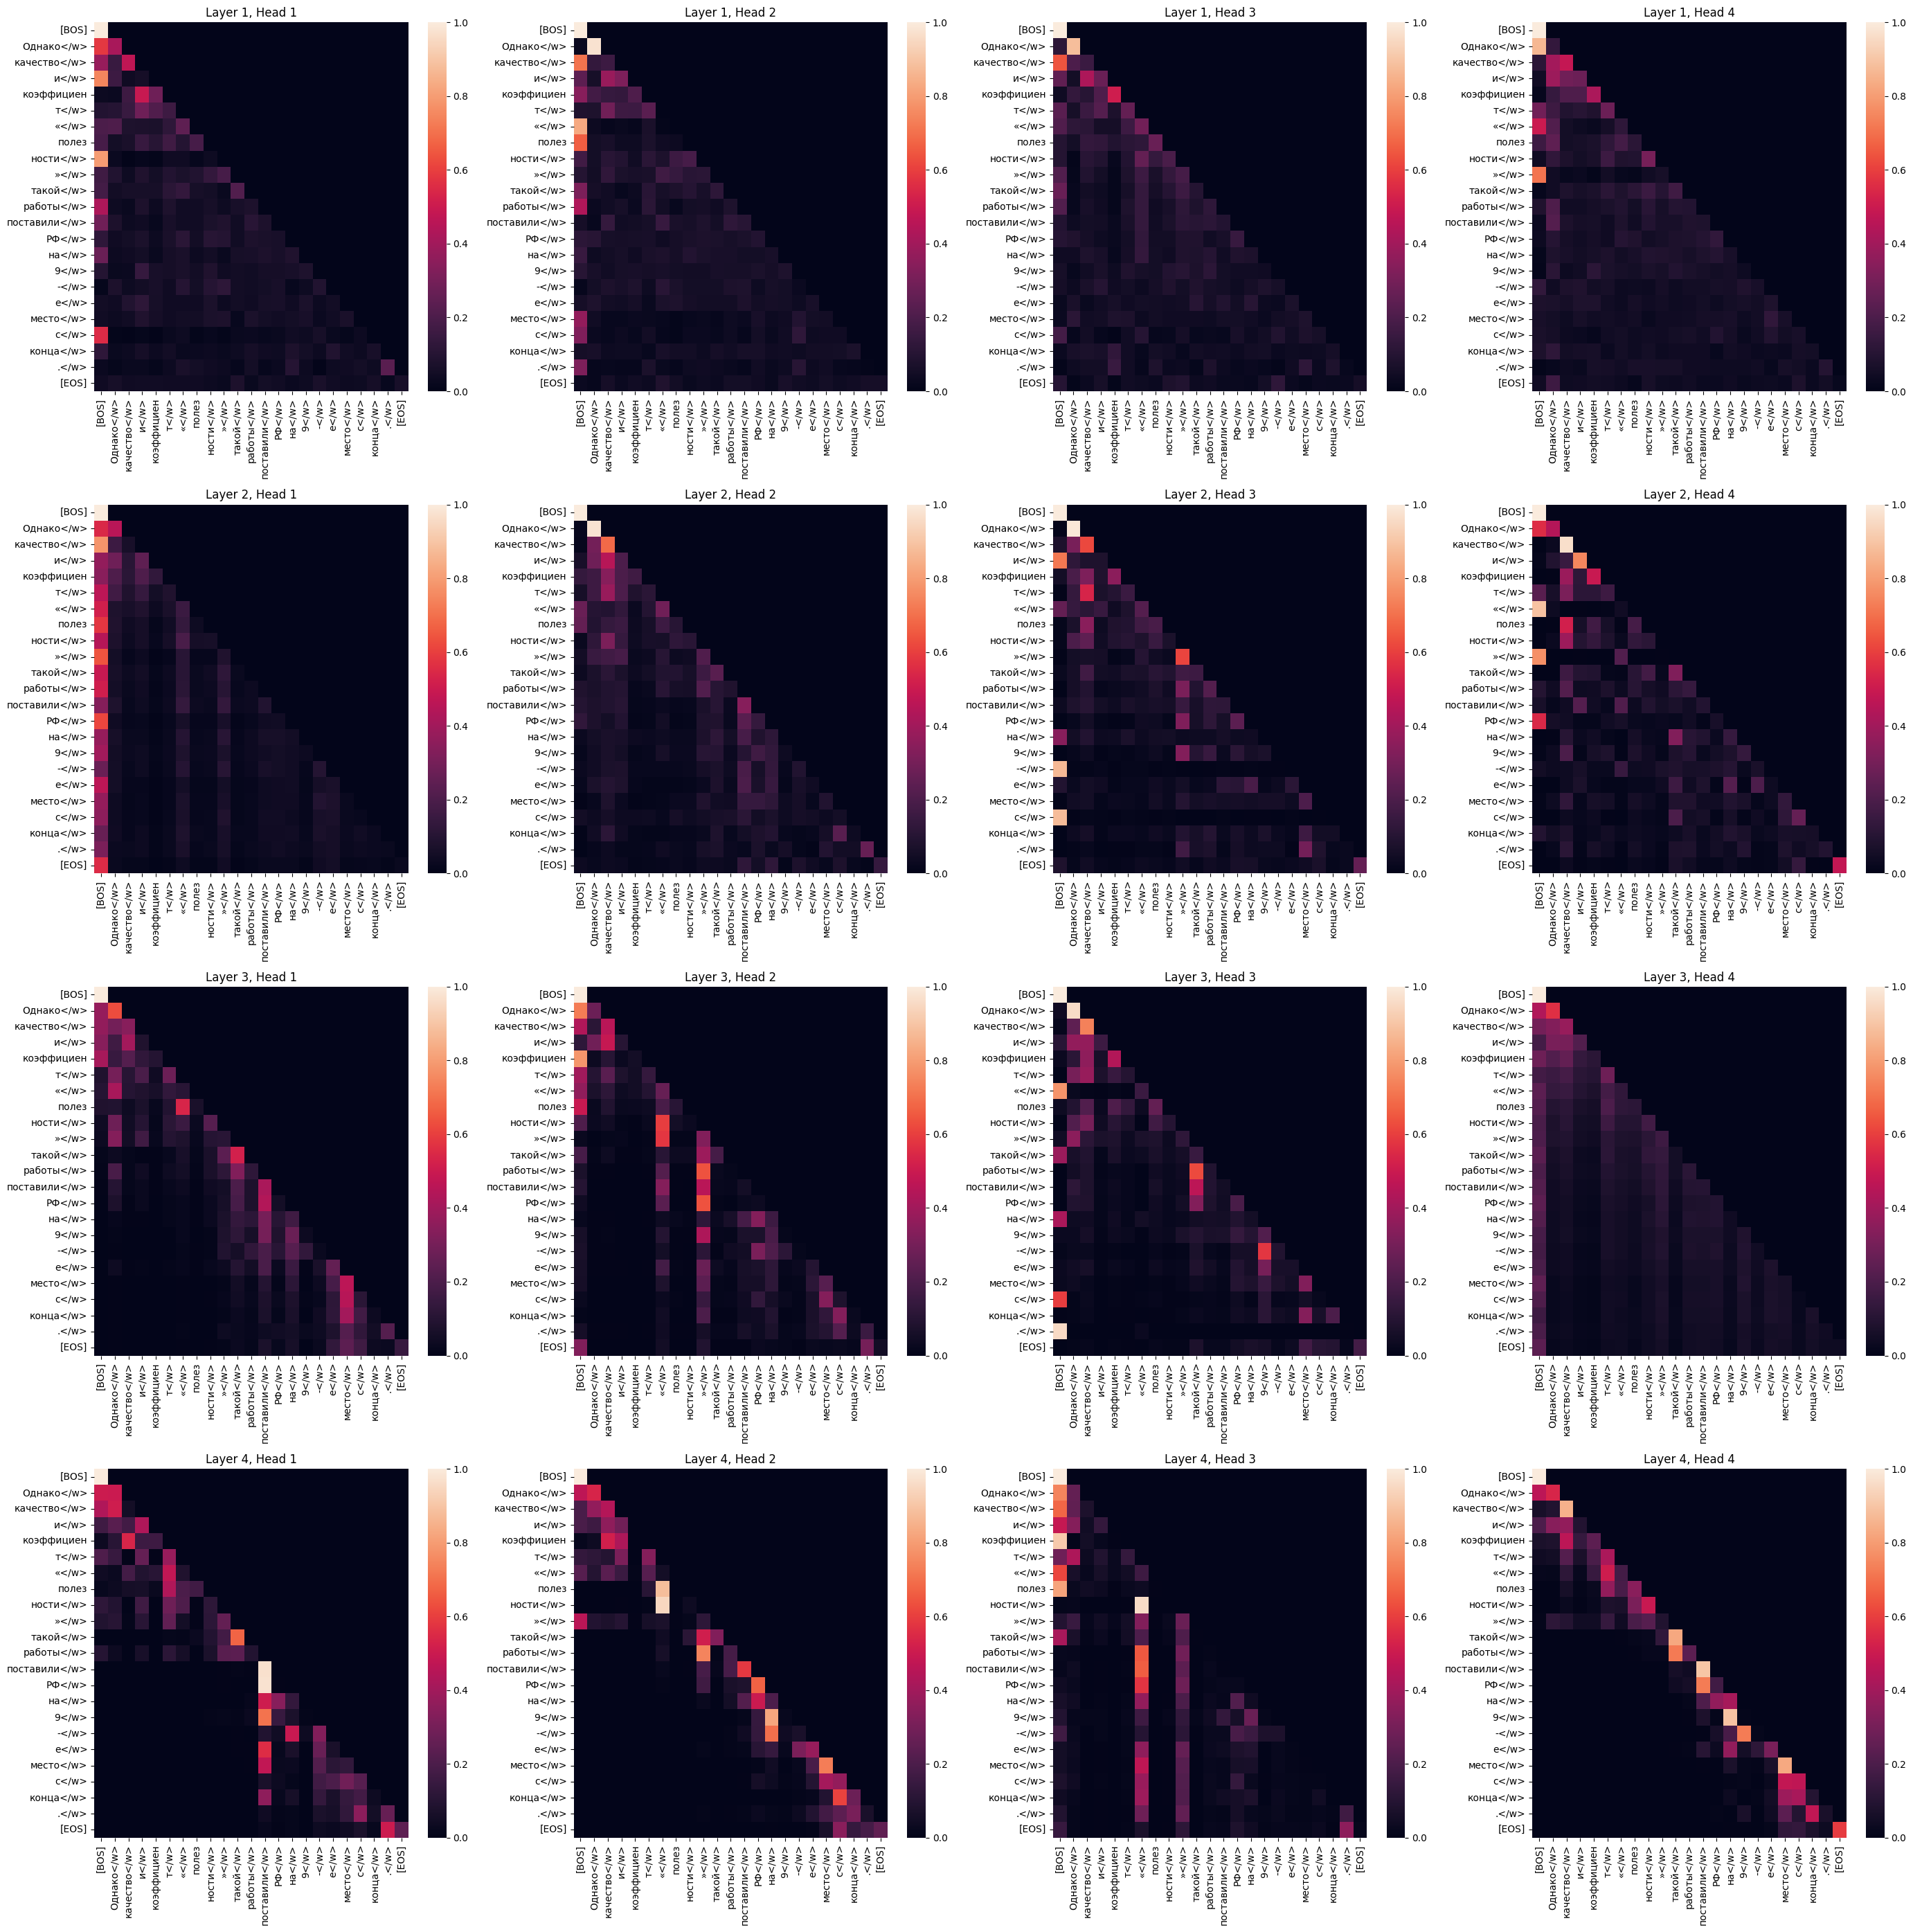

Epoch 2:


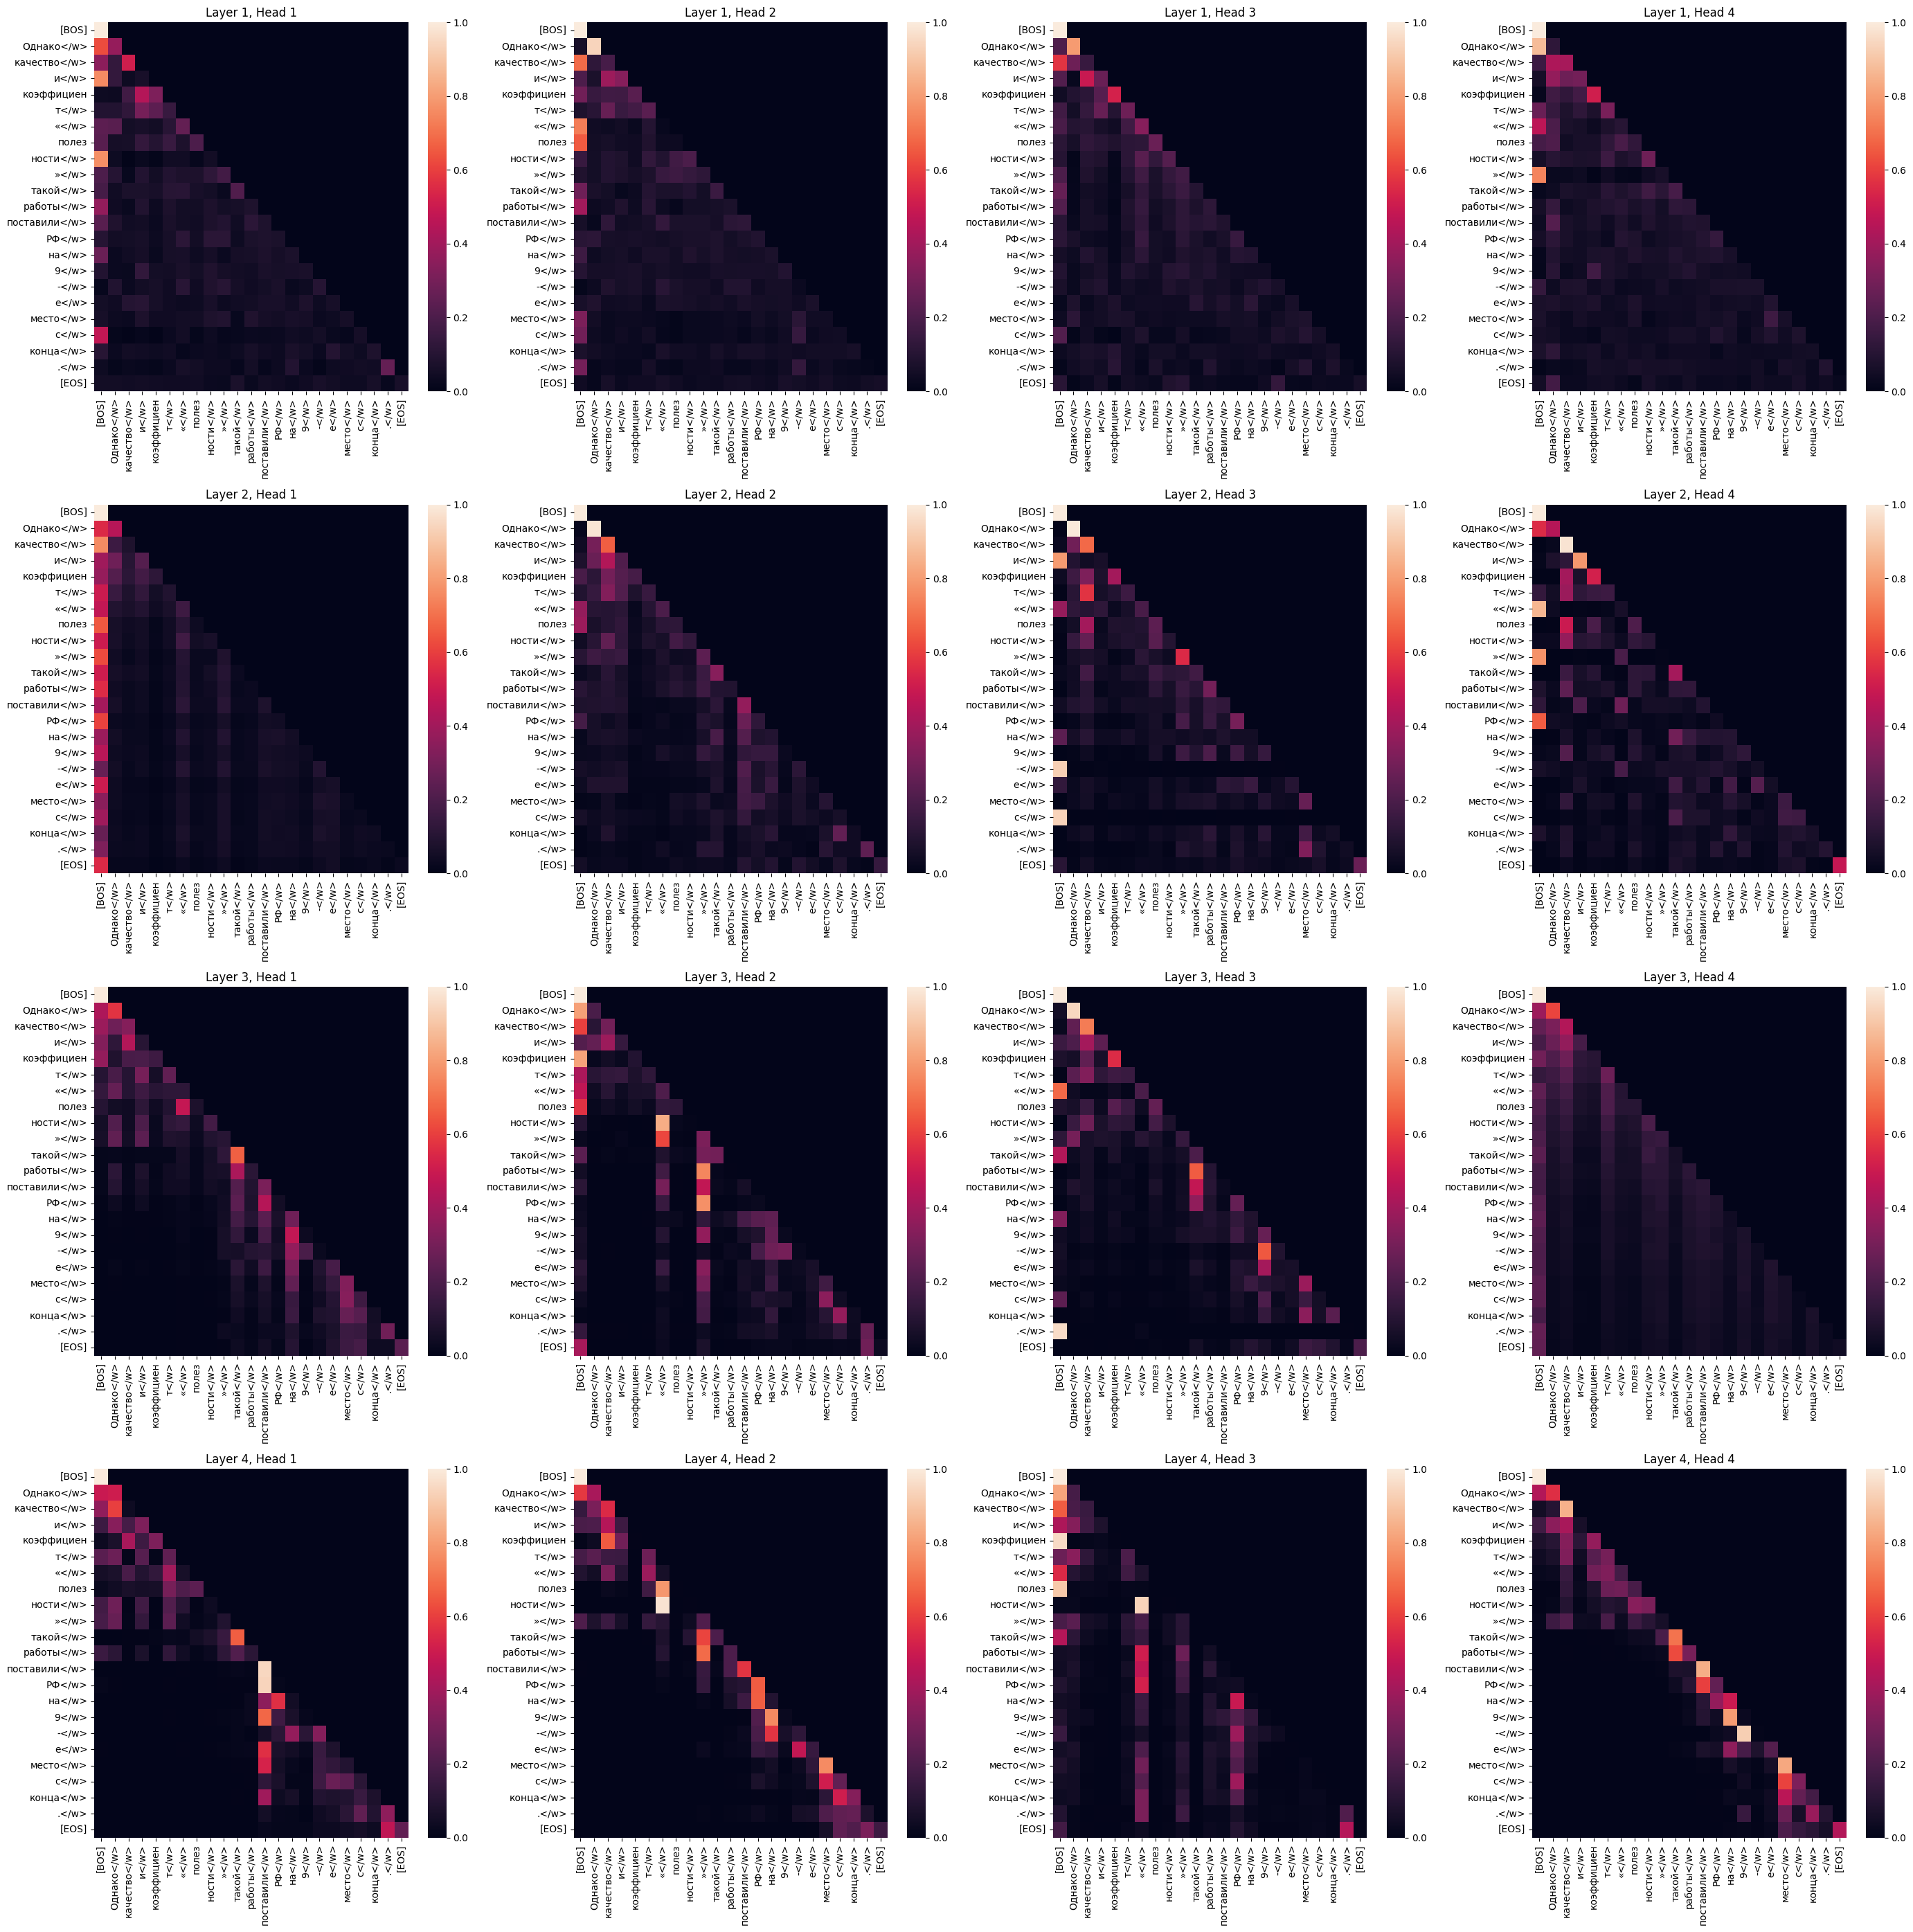

Epoch 3:


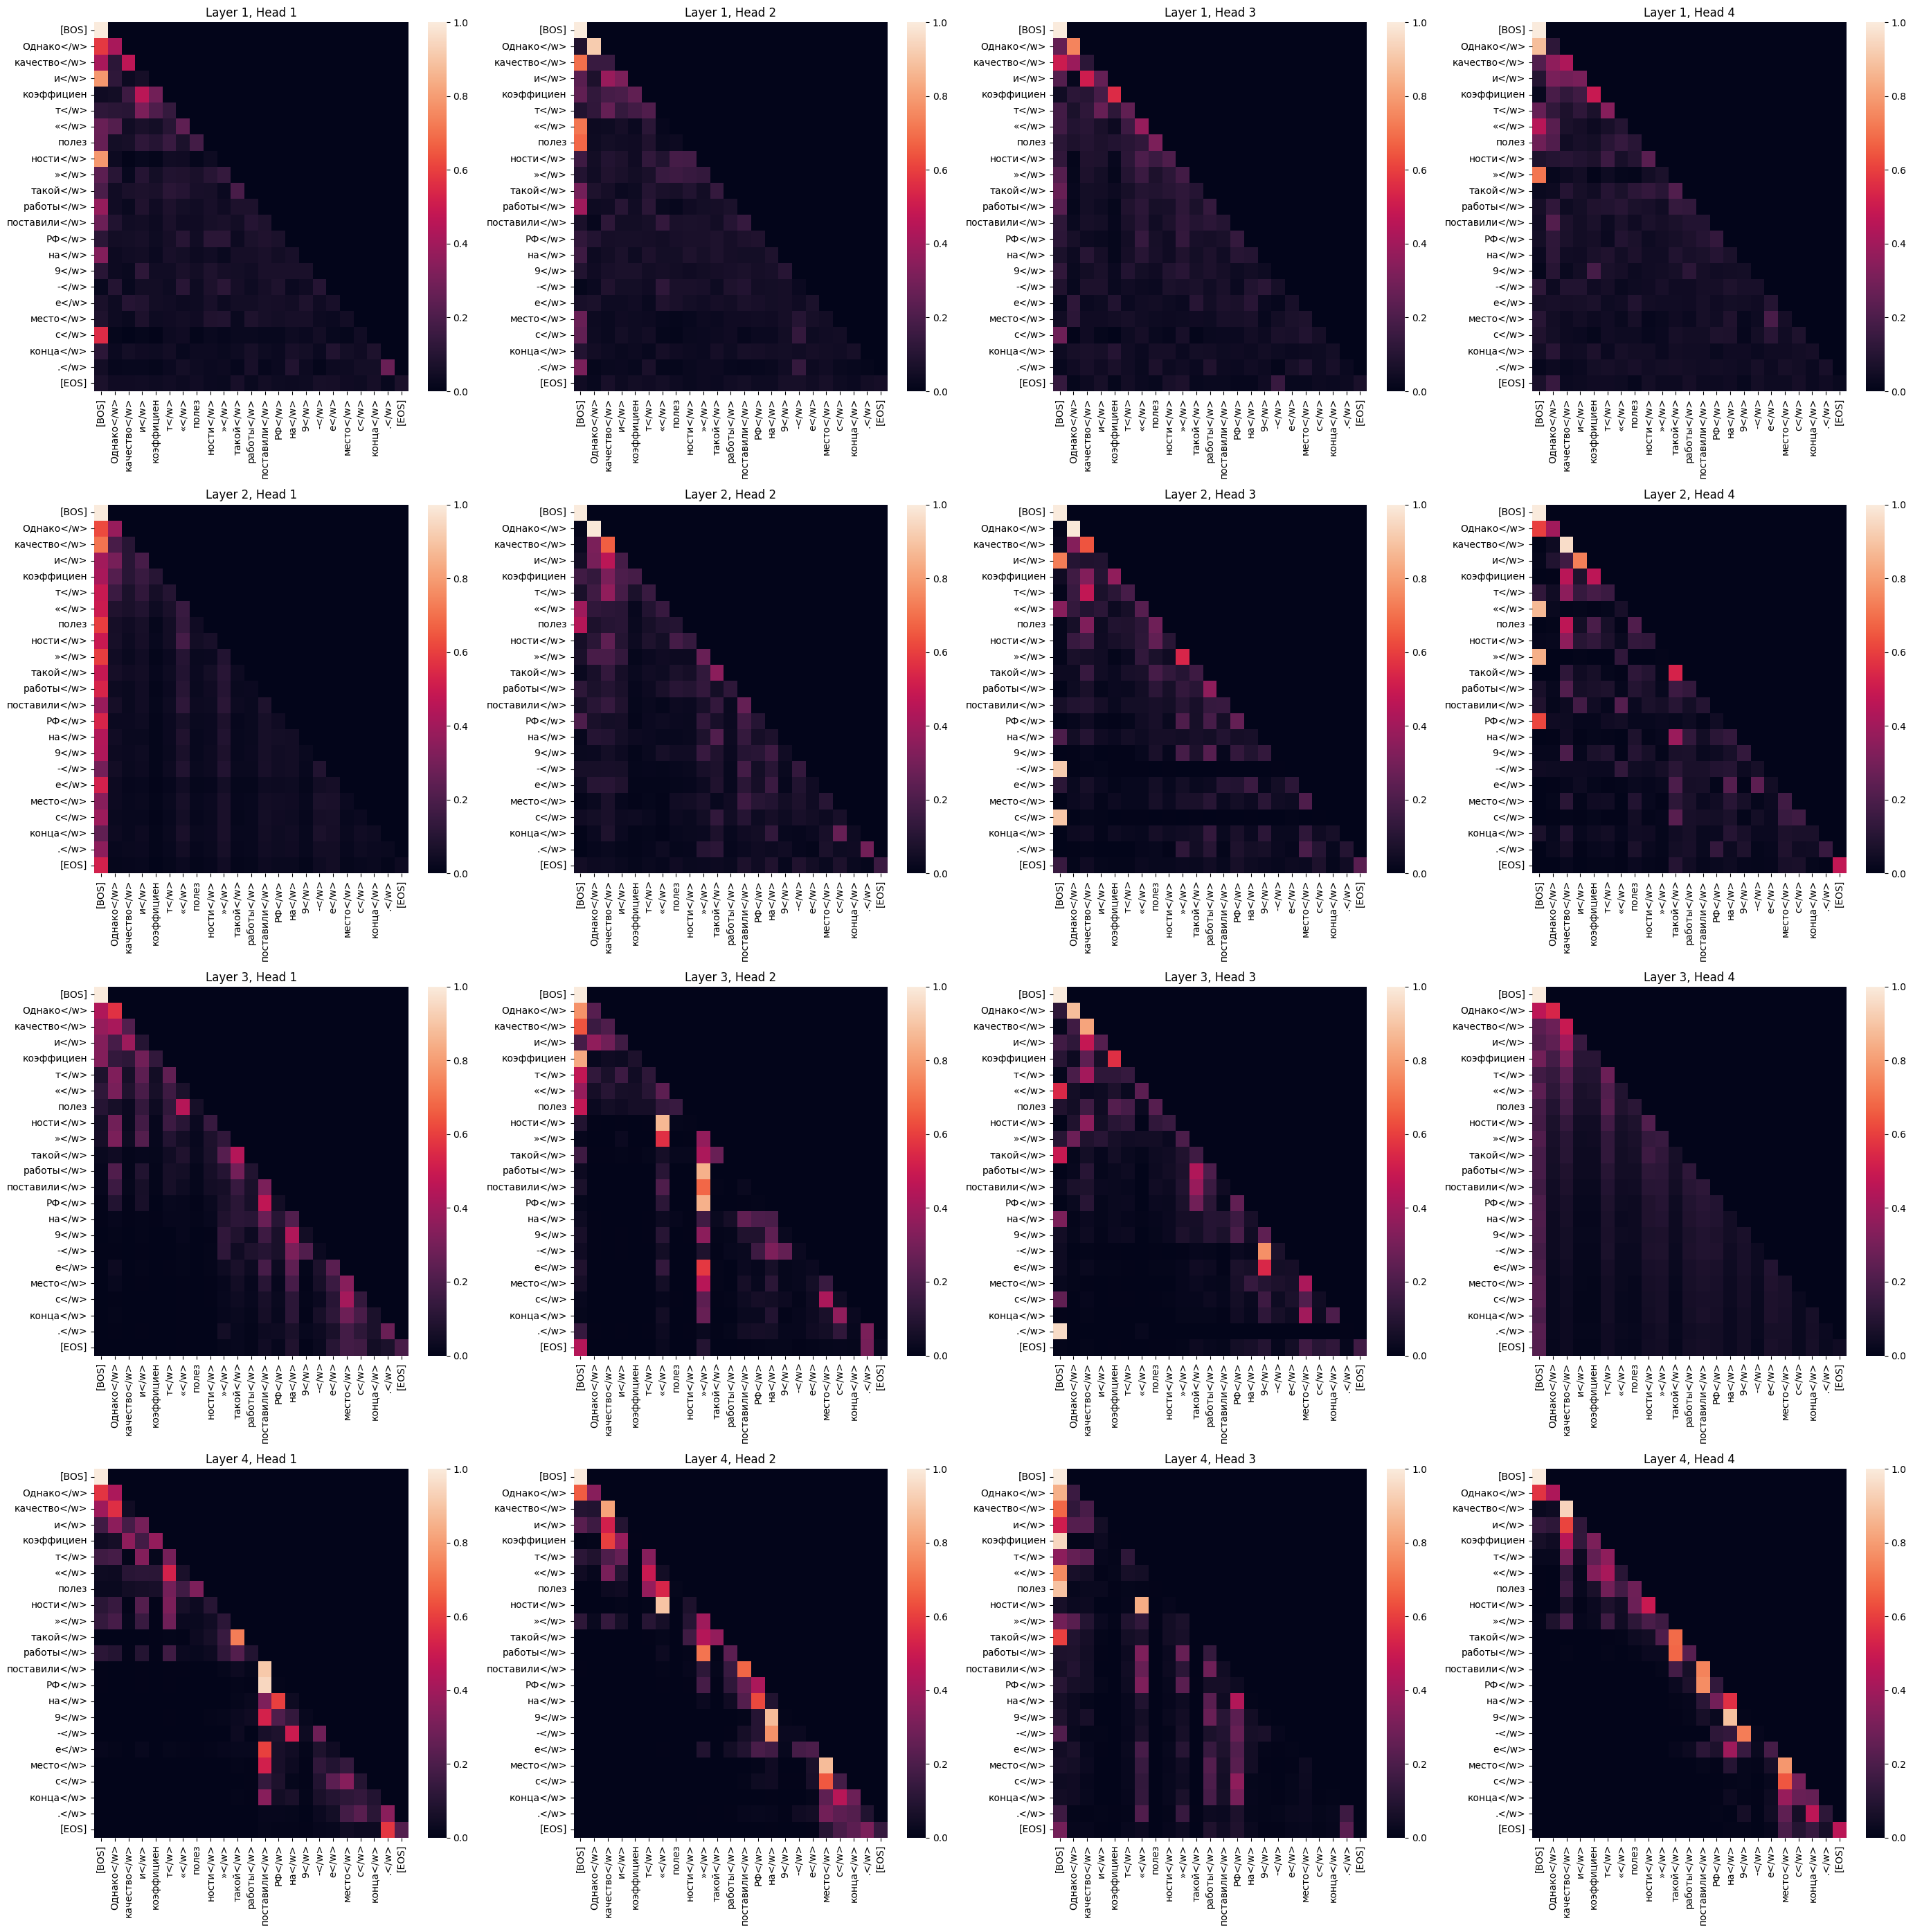

Epoch 4:


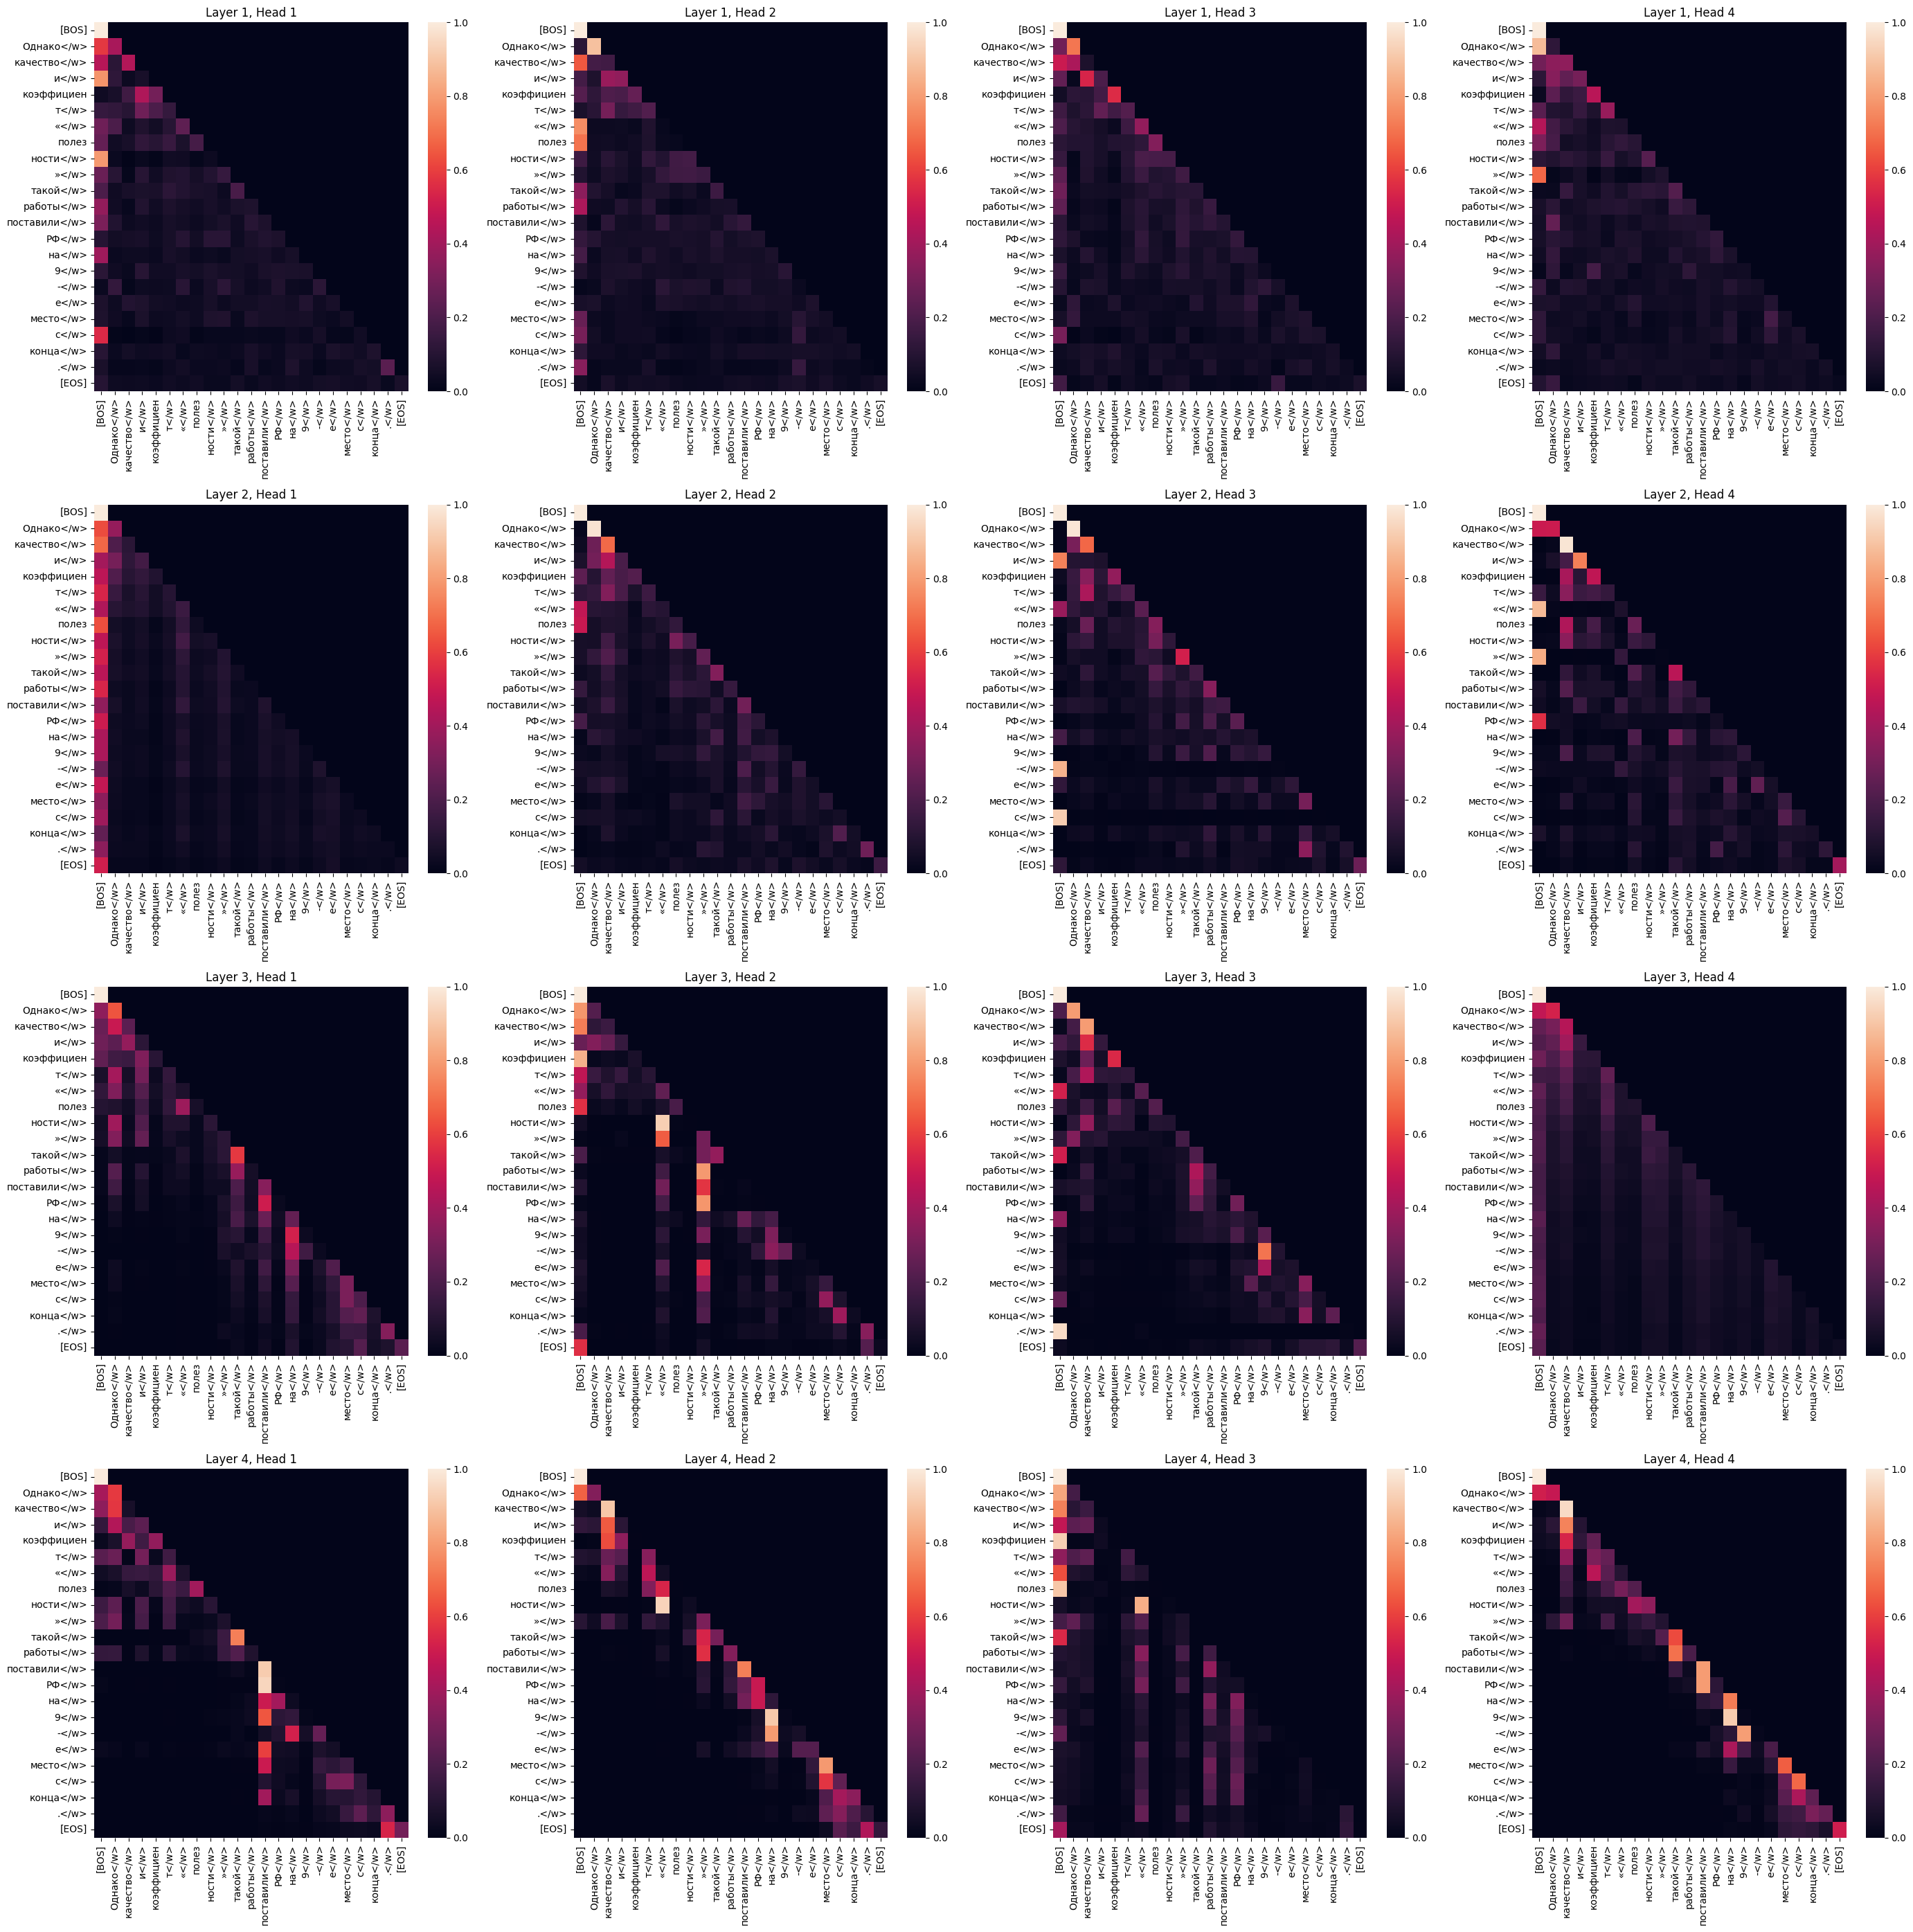

Epoch 5:


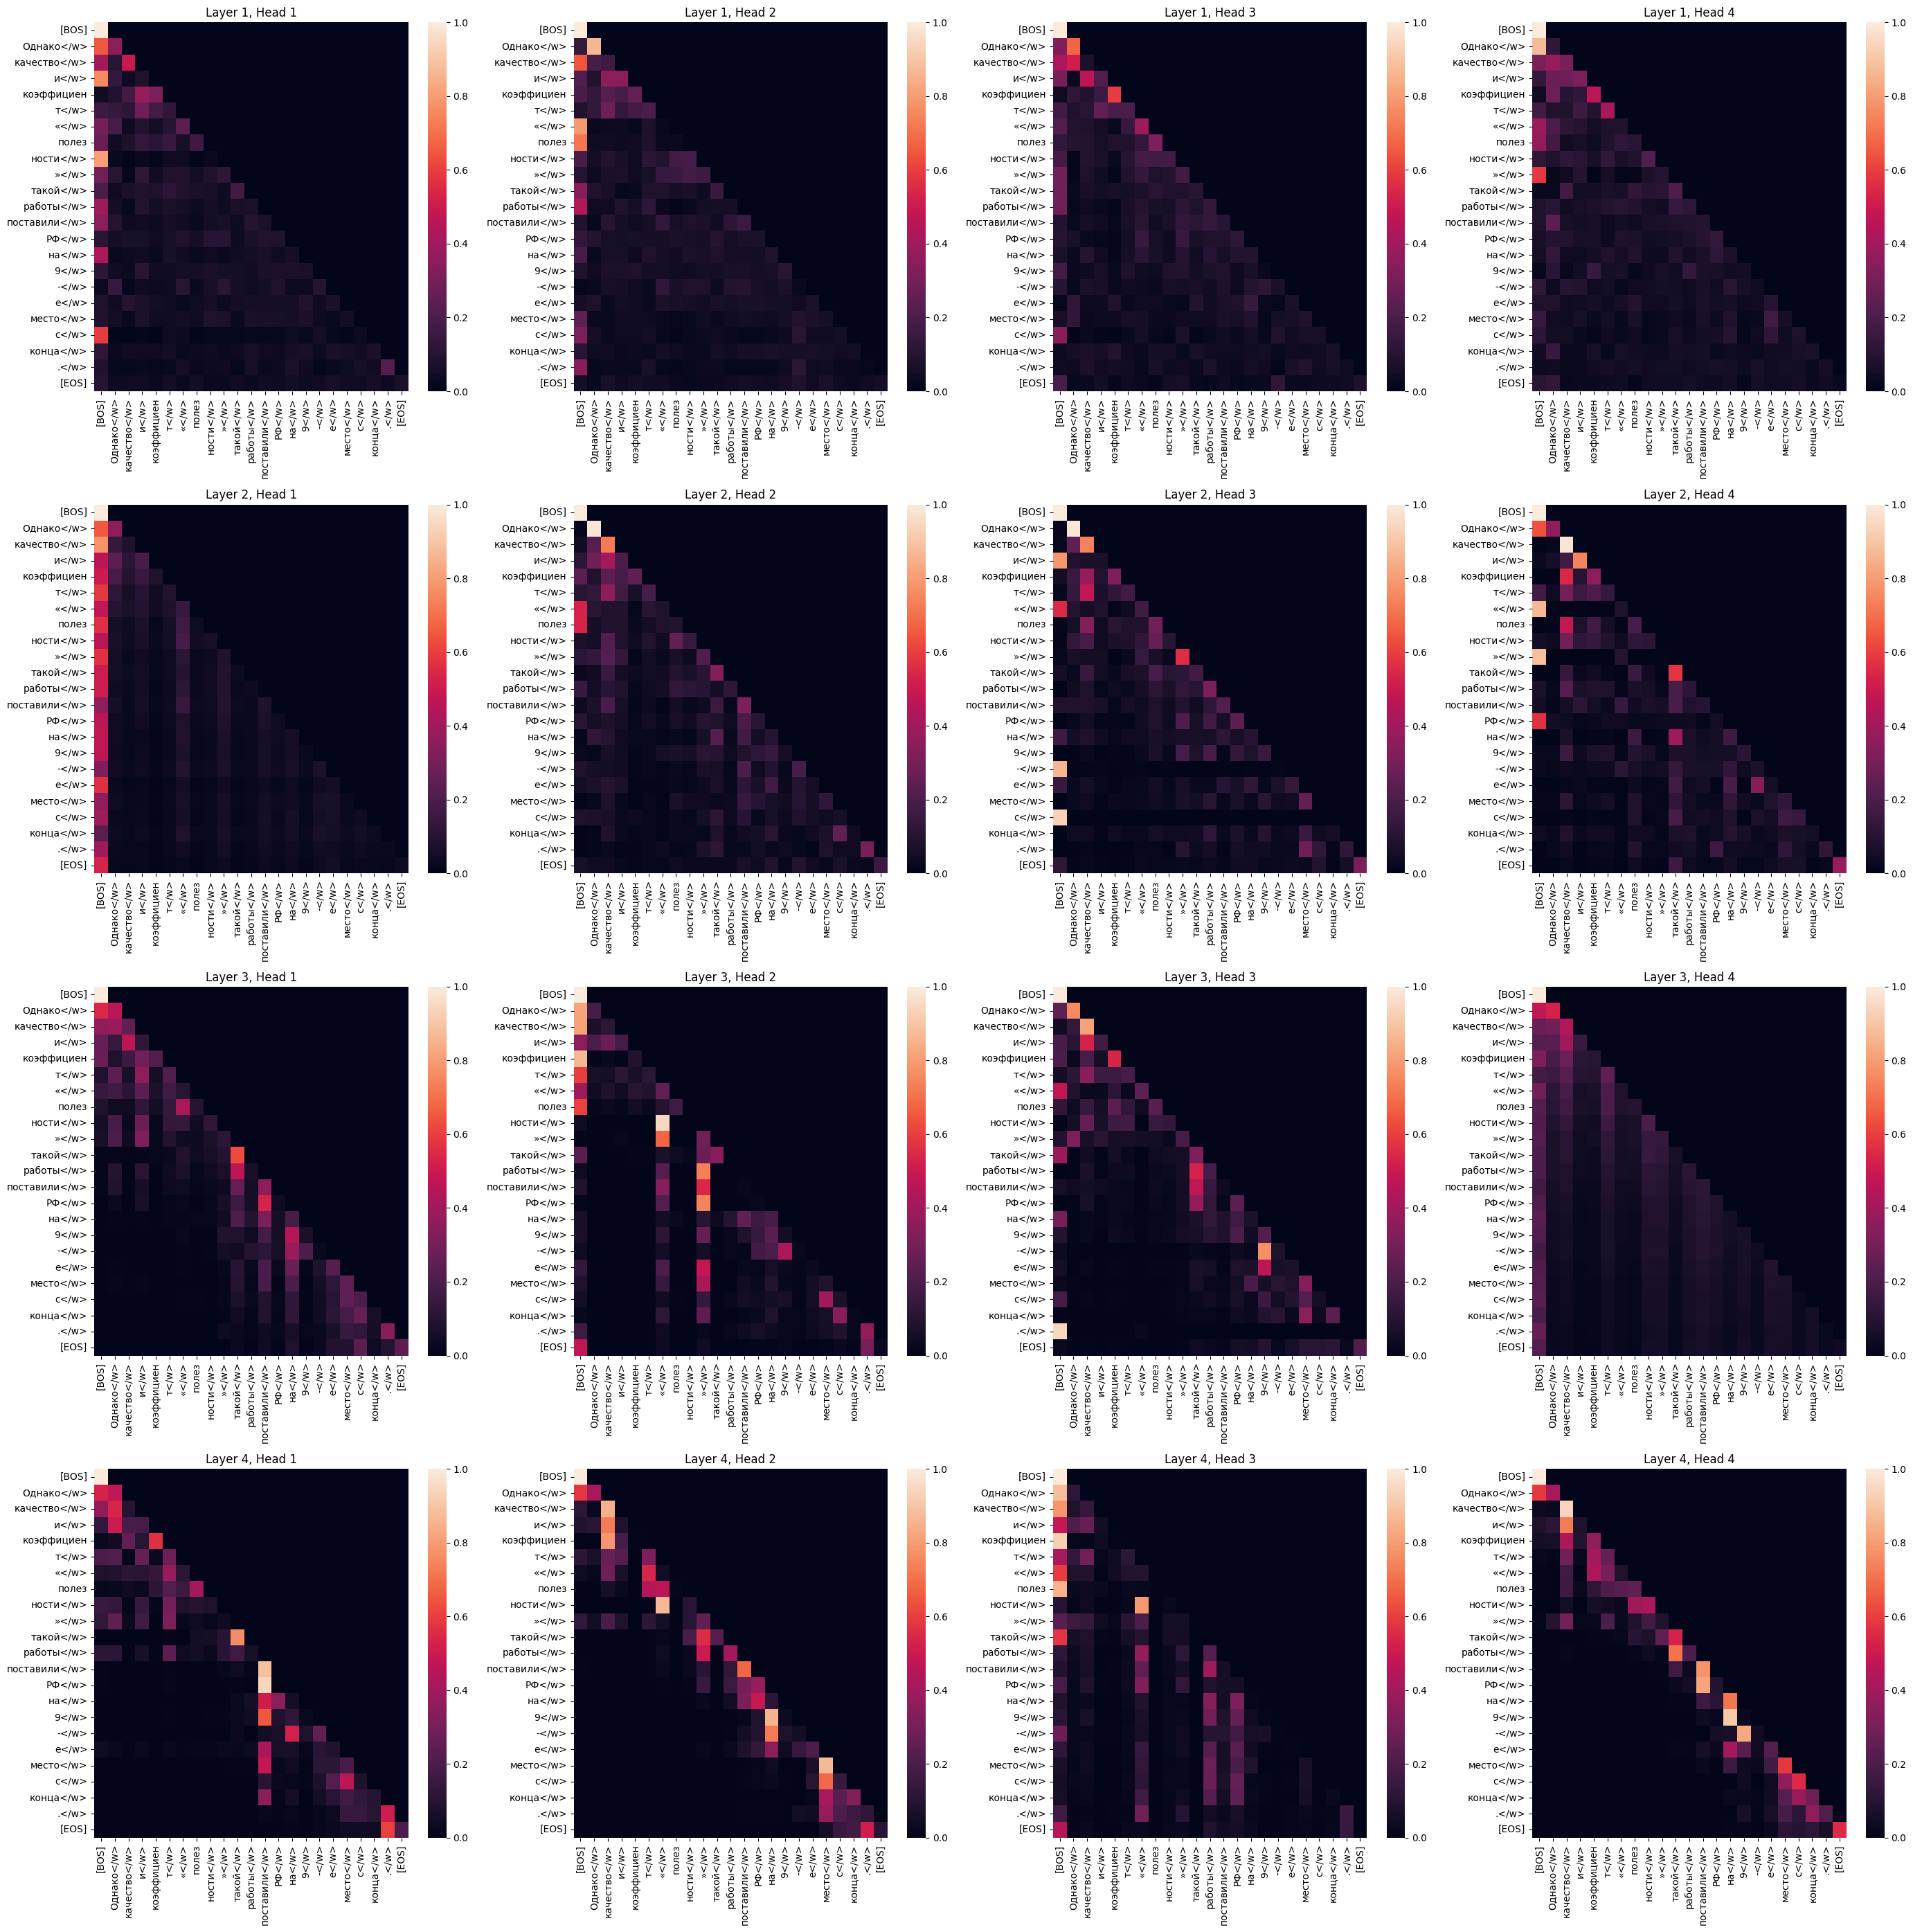

Epoch 6:


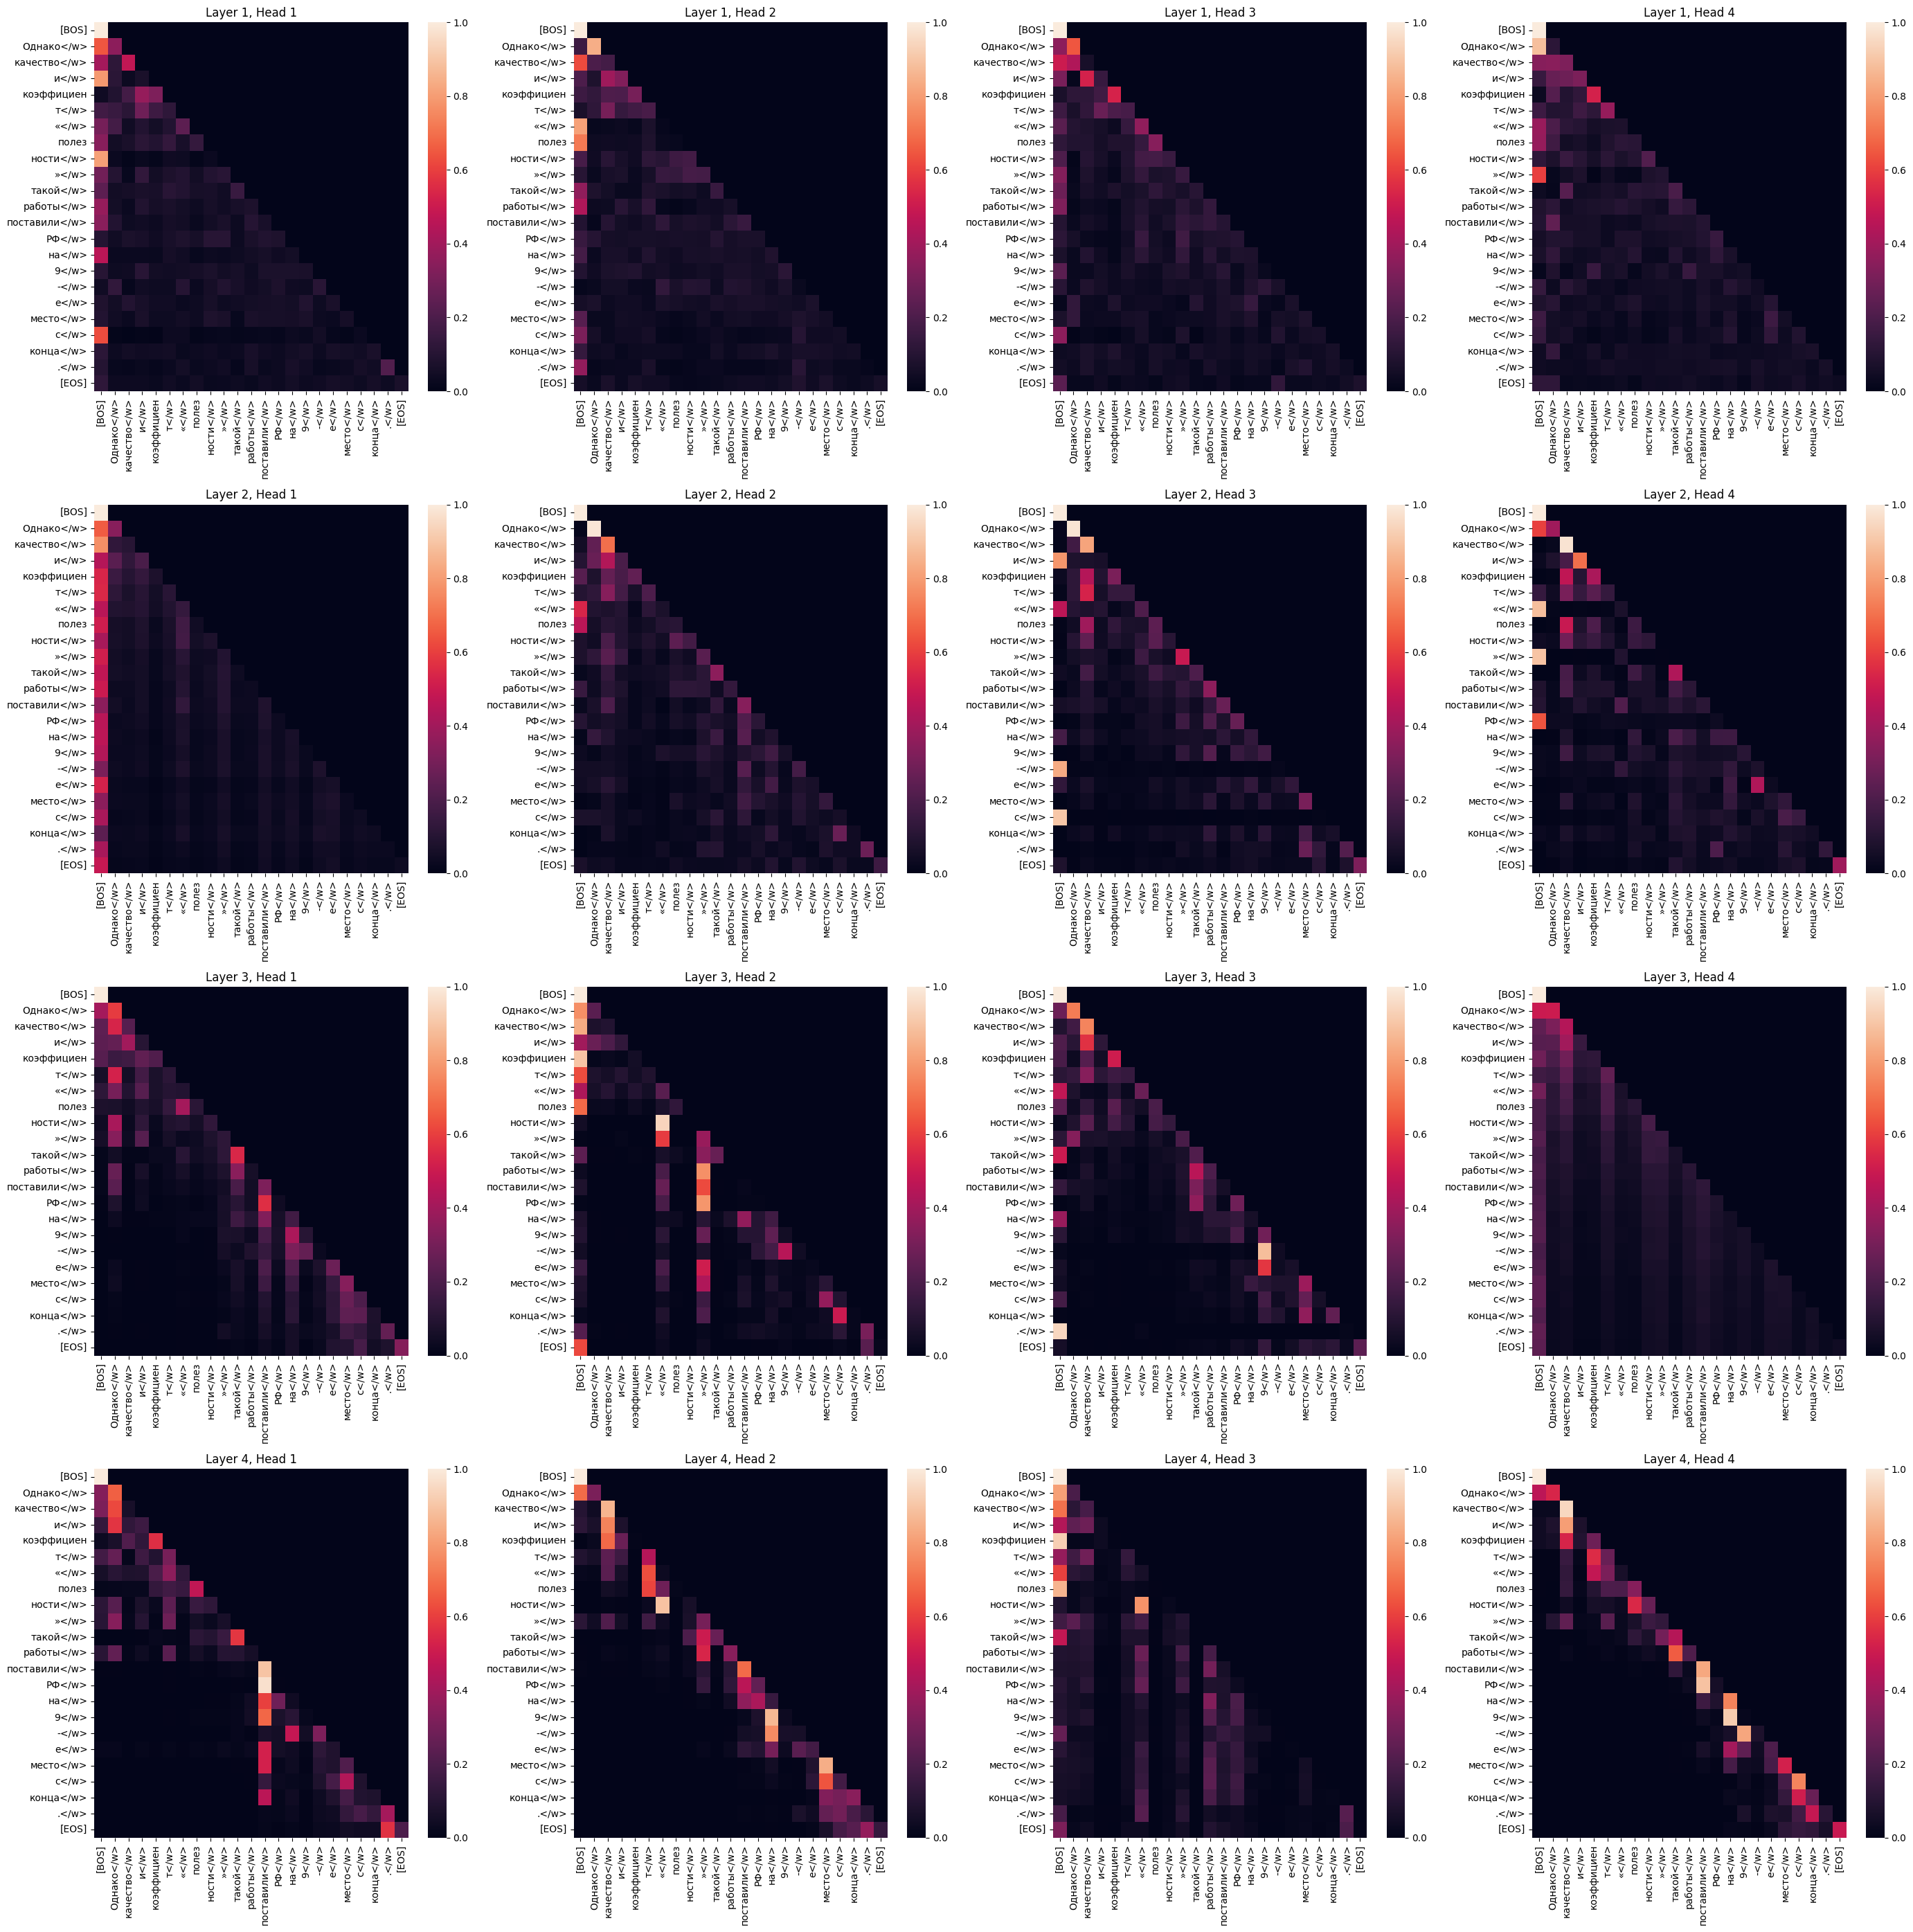

Epoch 7:


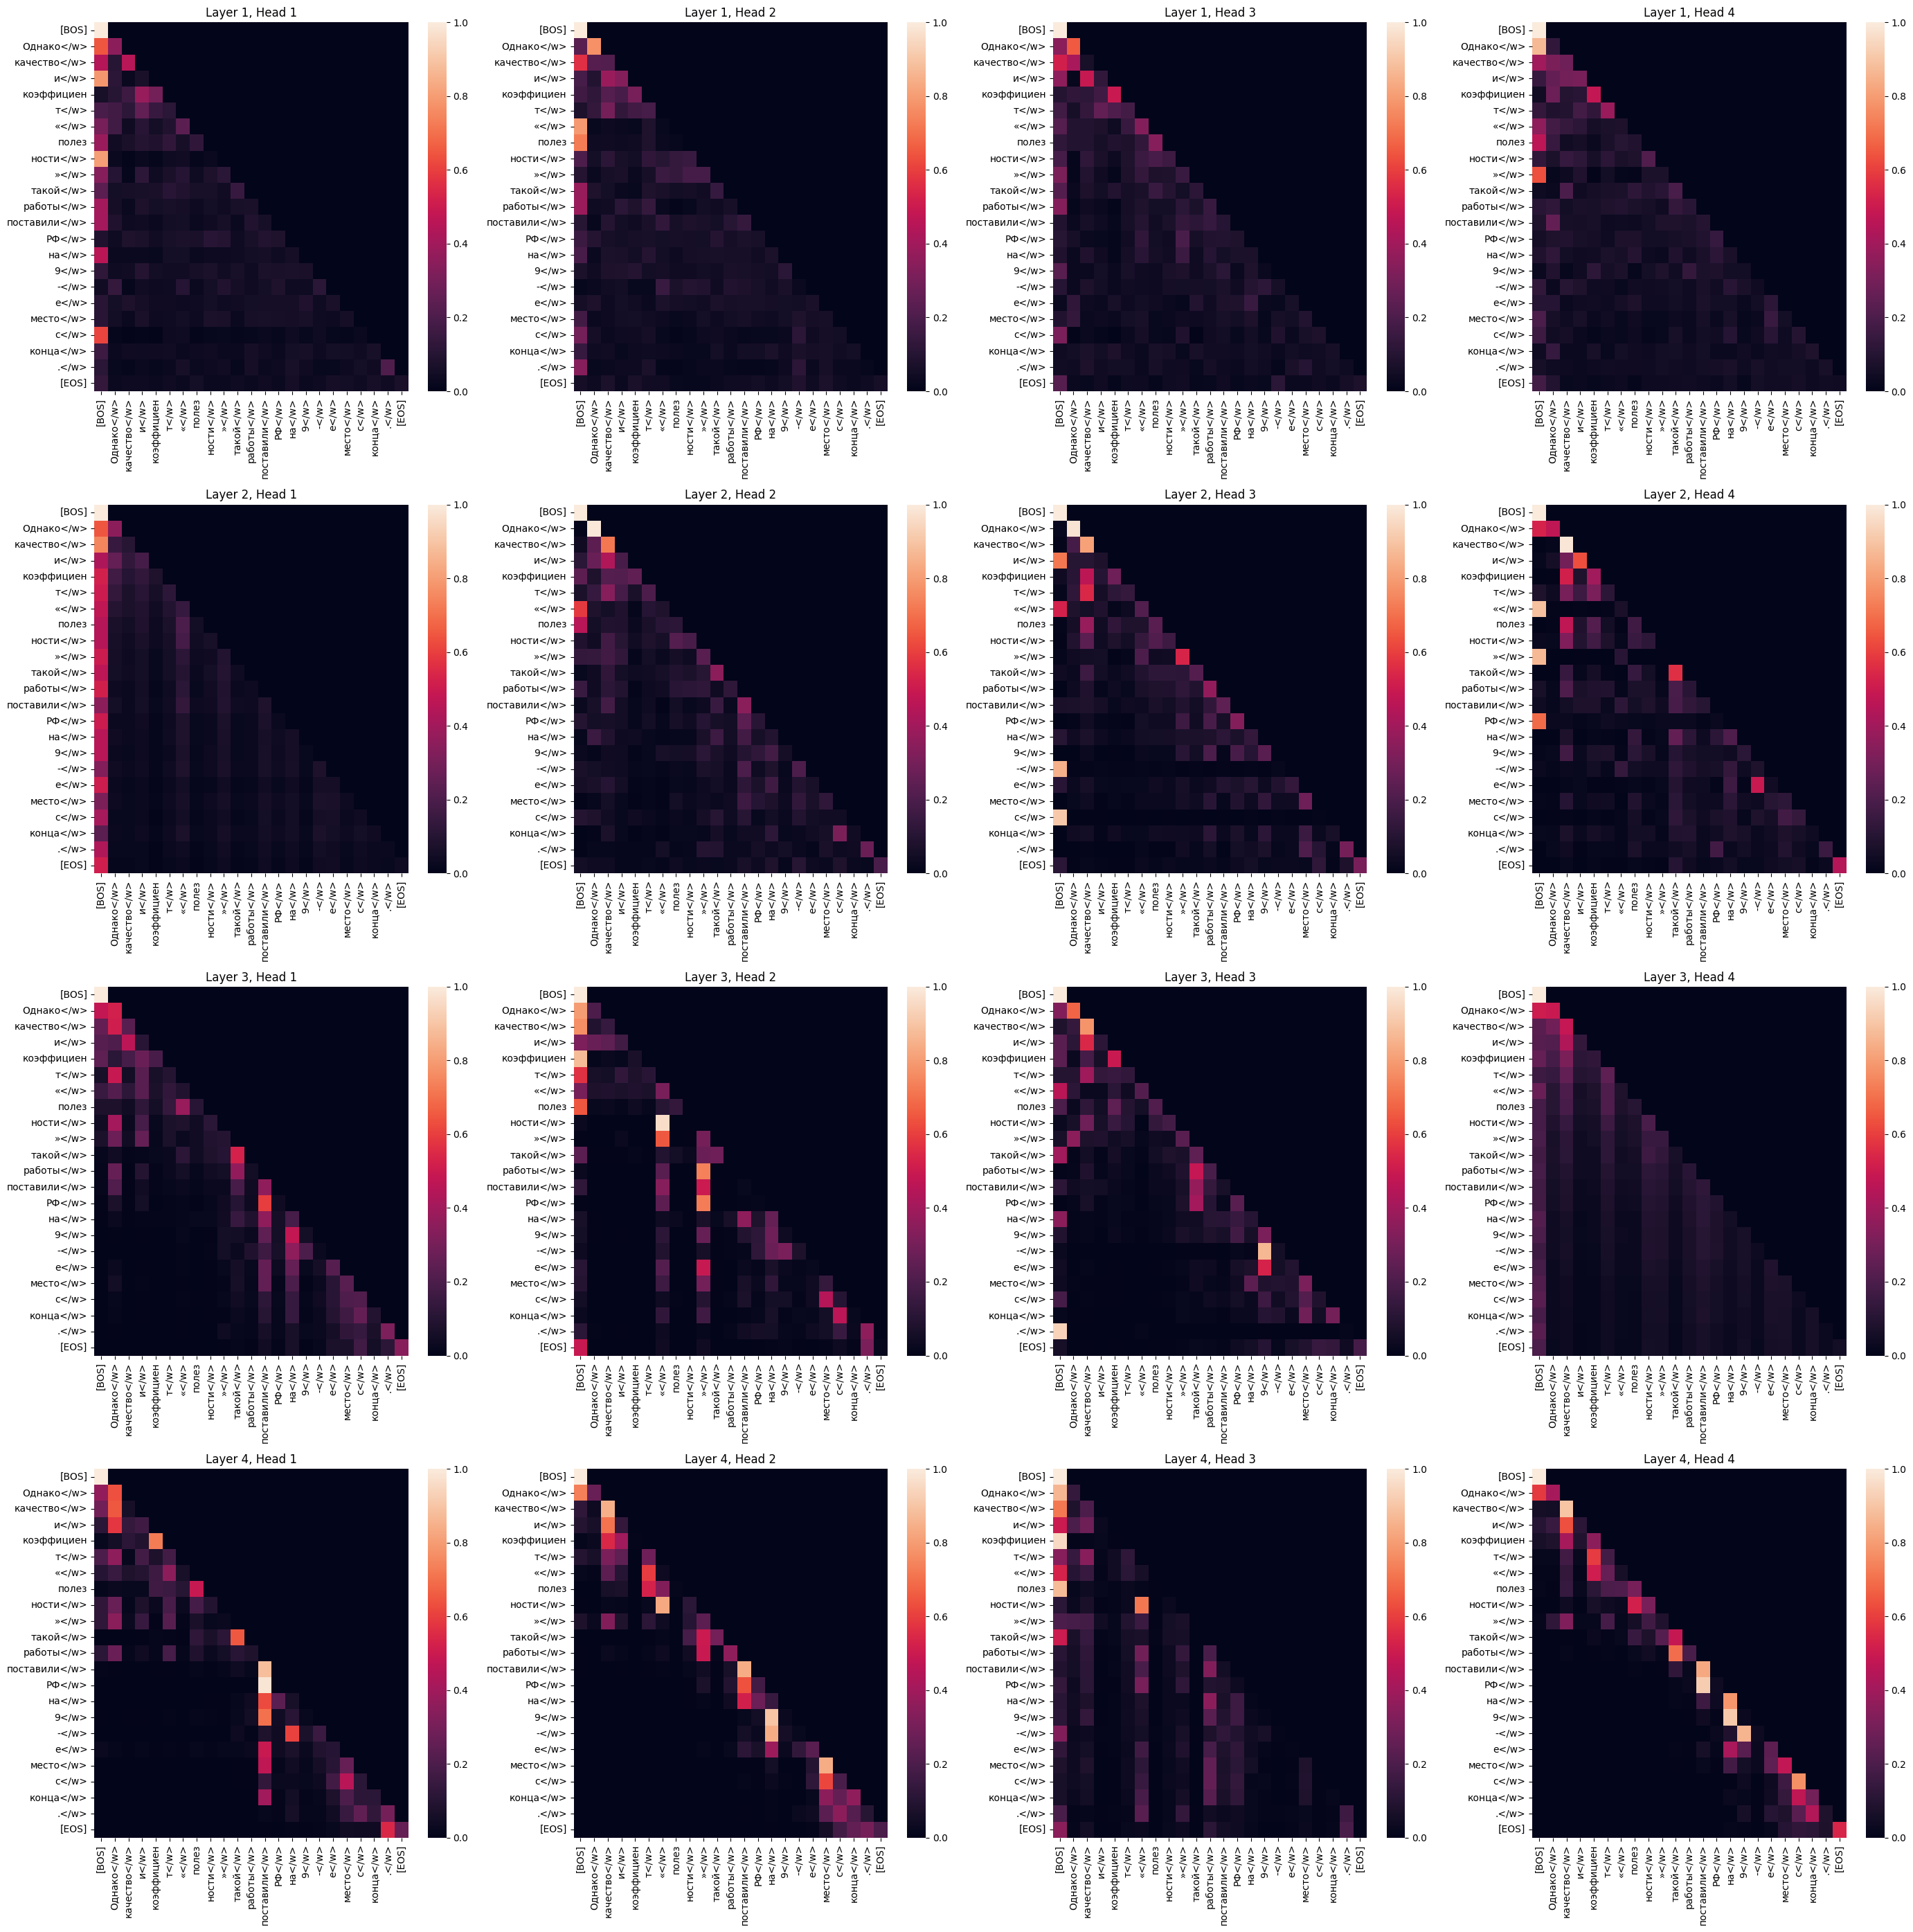

Epoch 8:


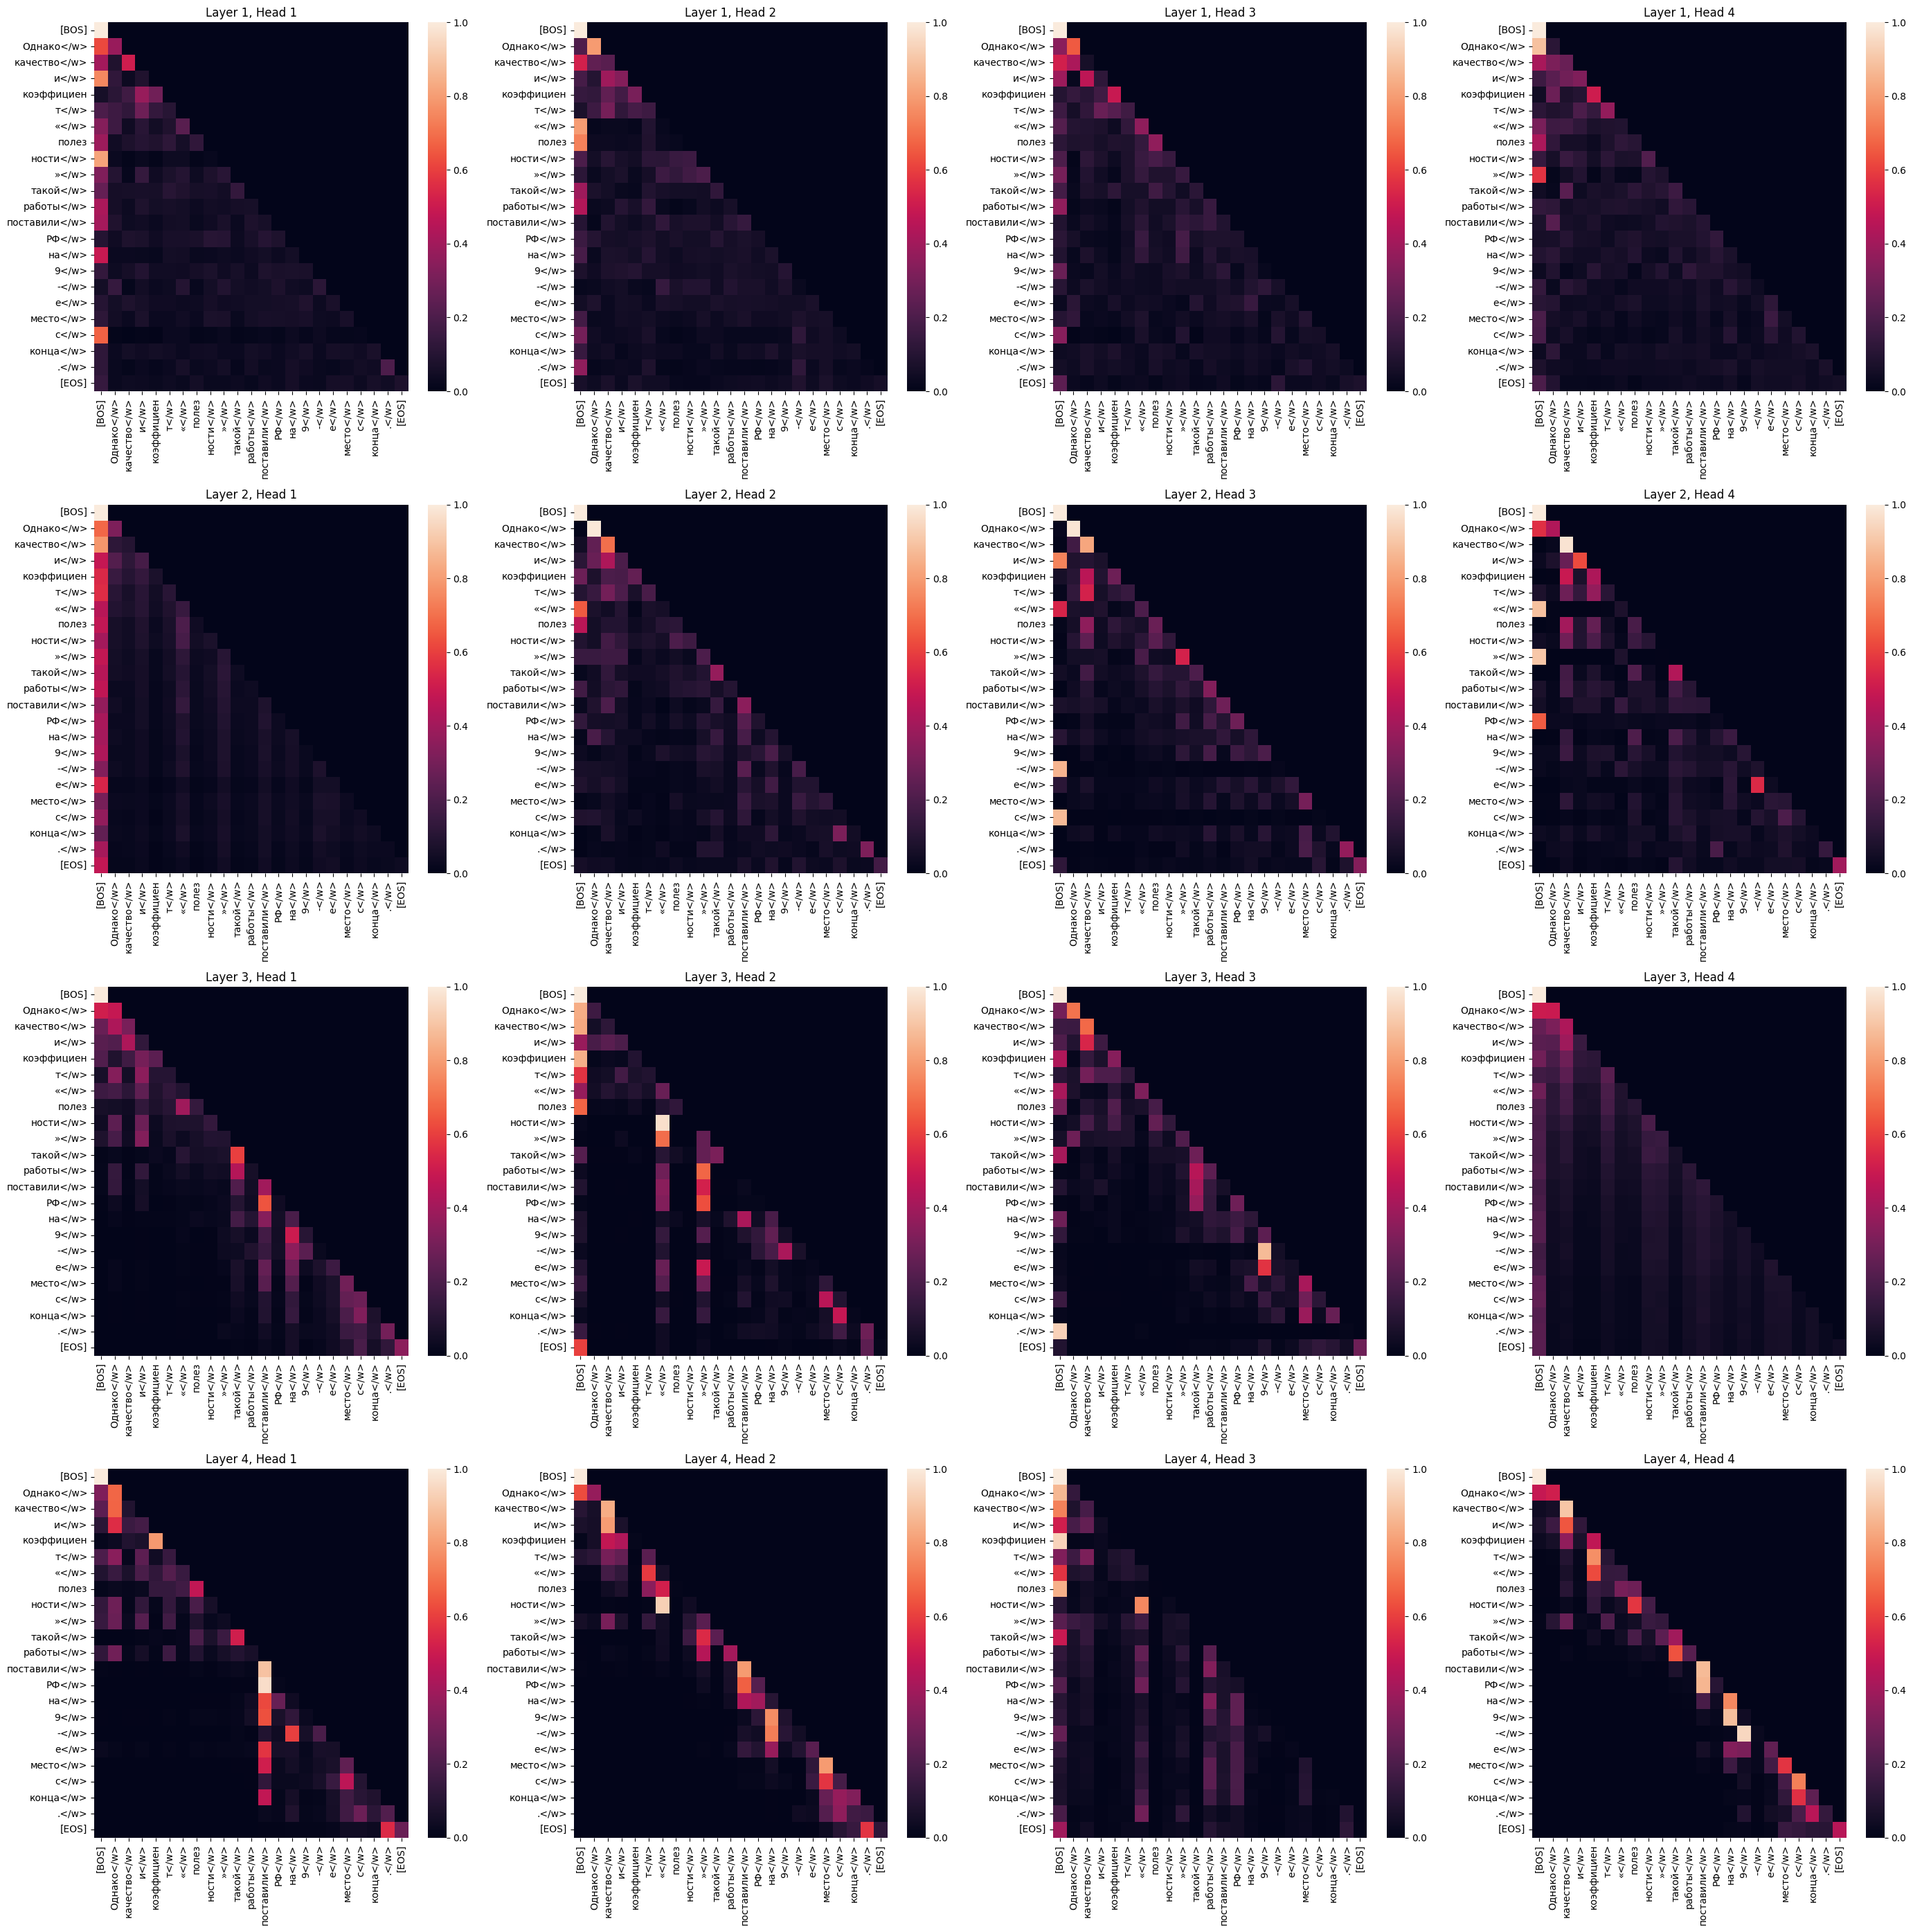

Epoch 9:


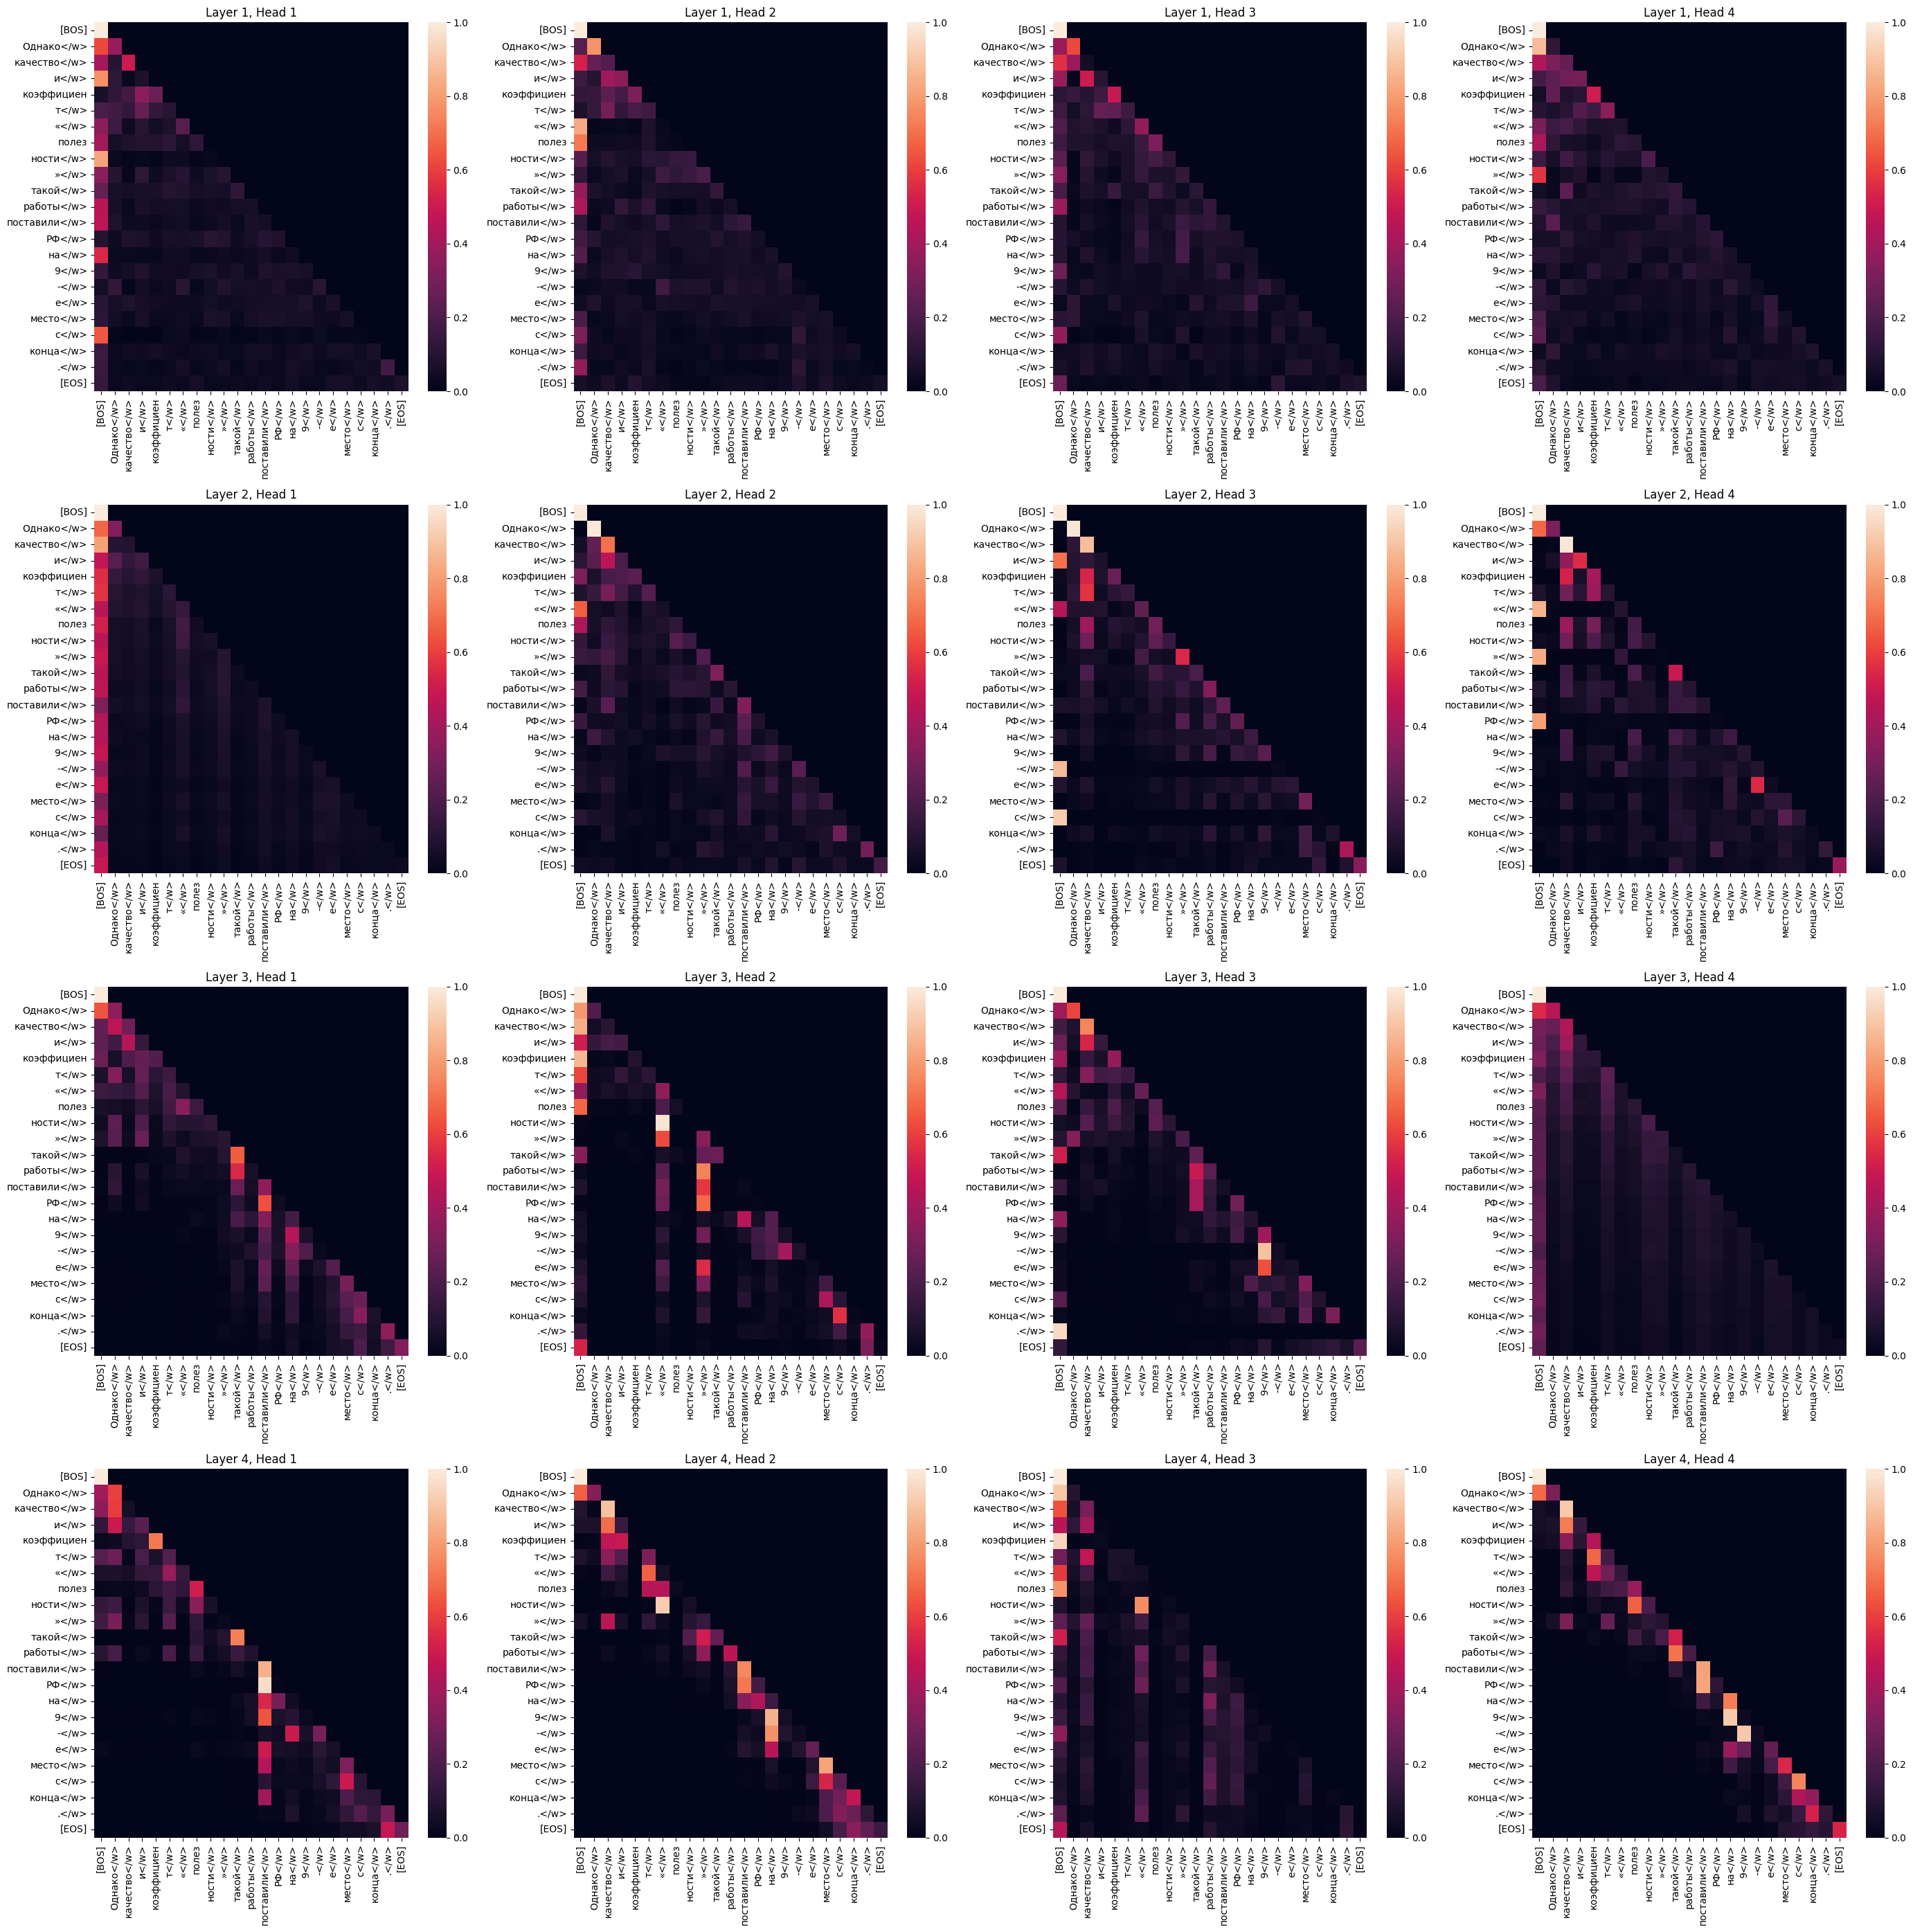

Epoch 10:


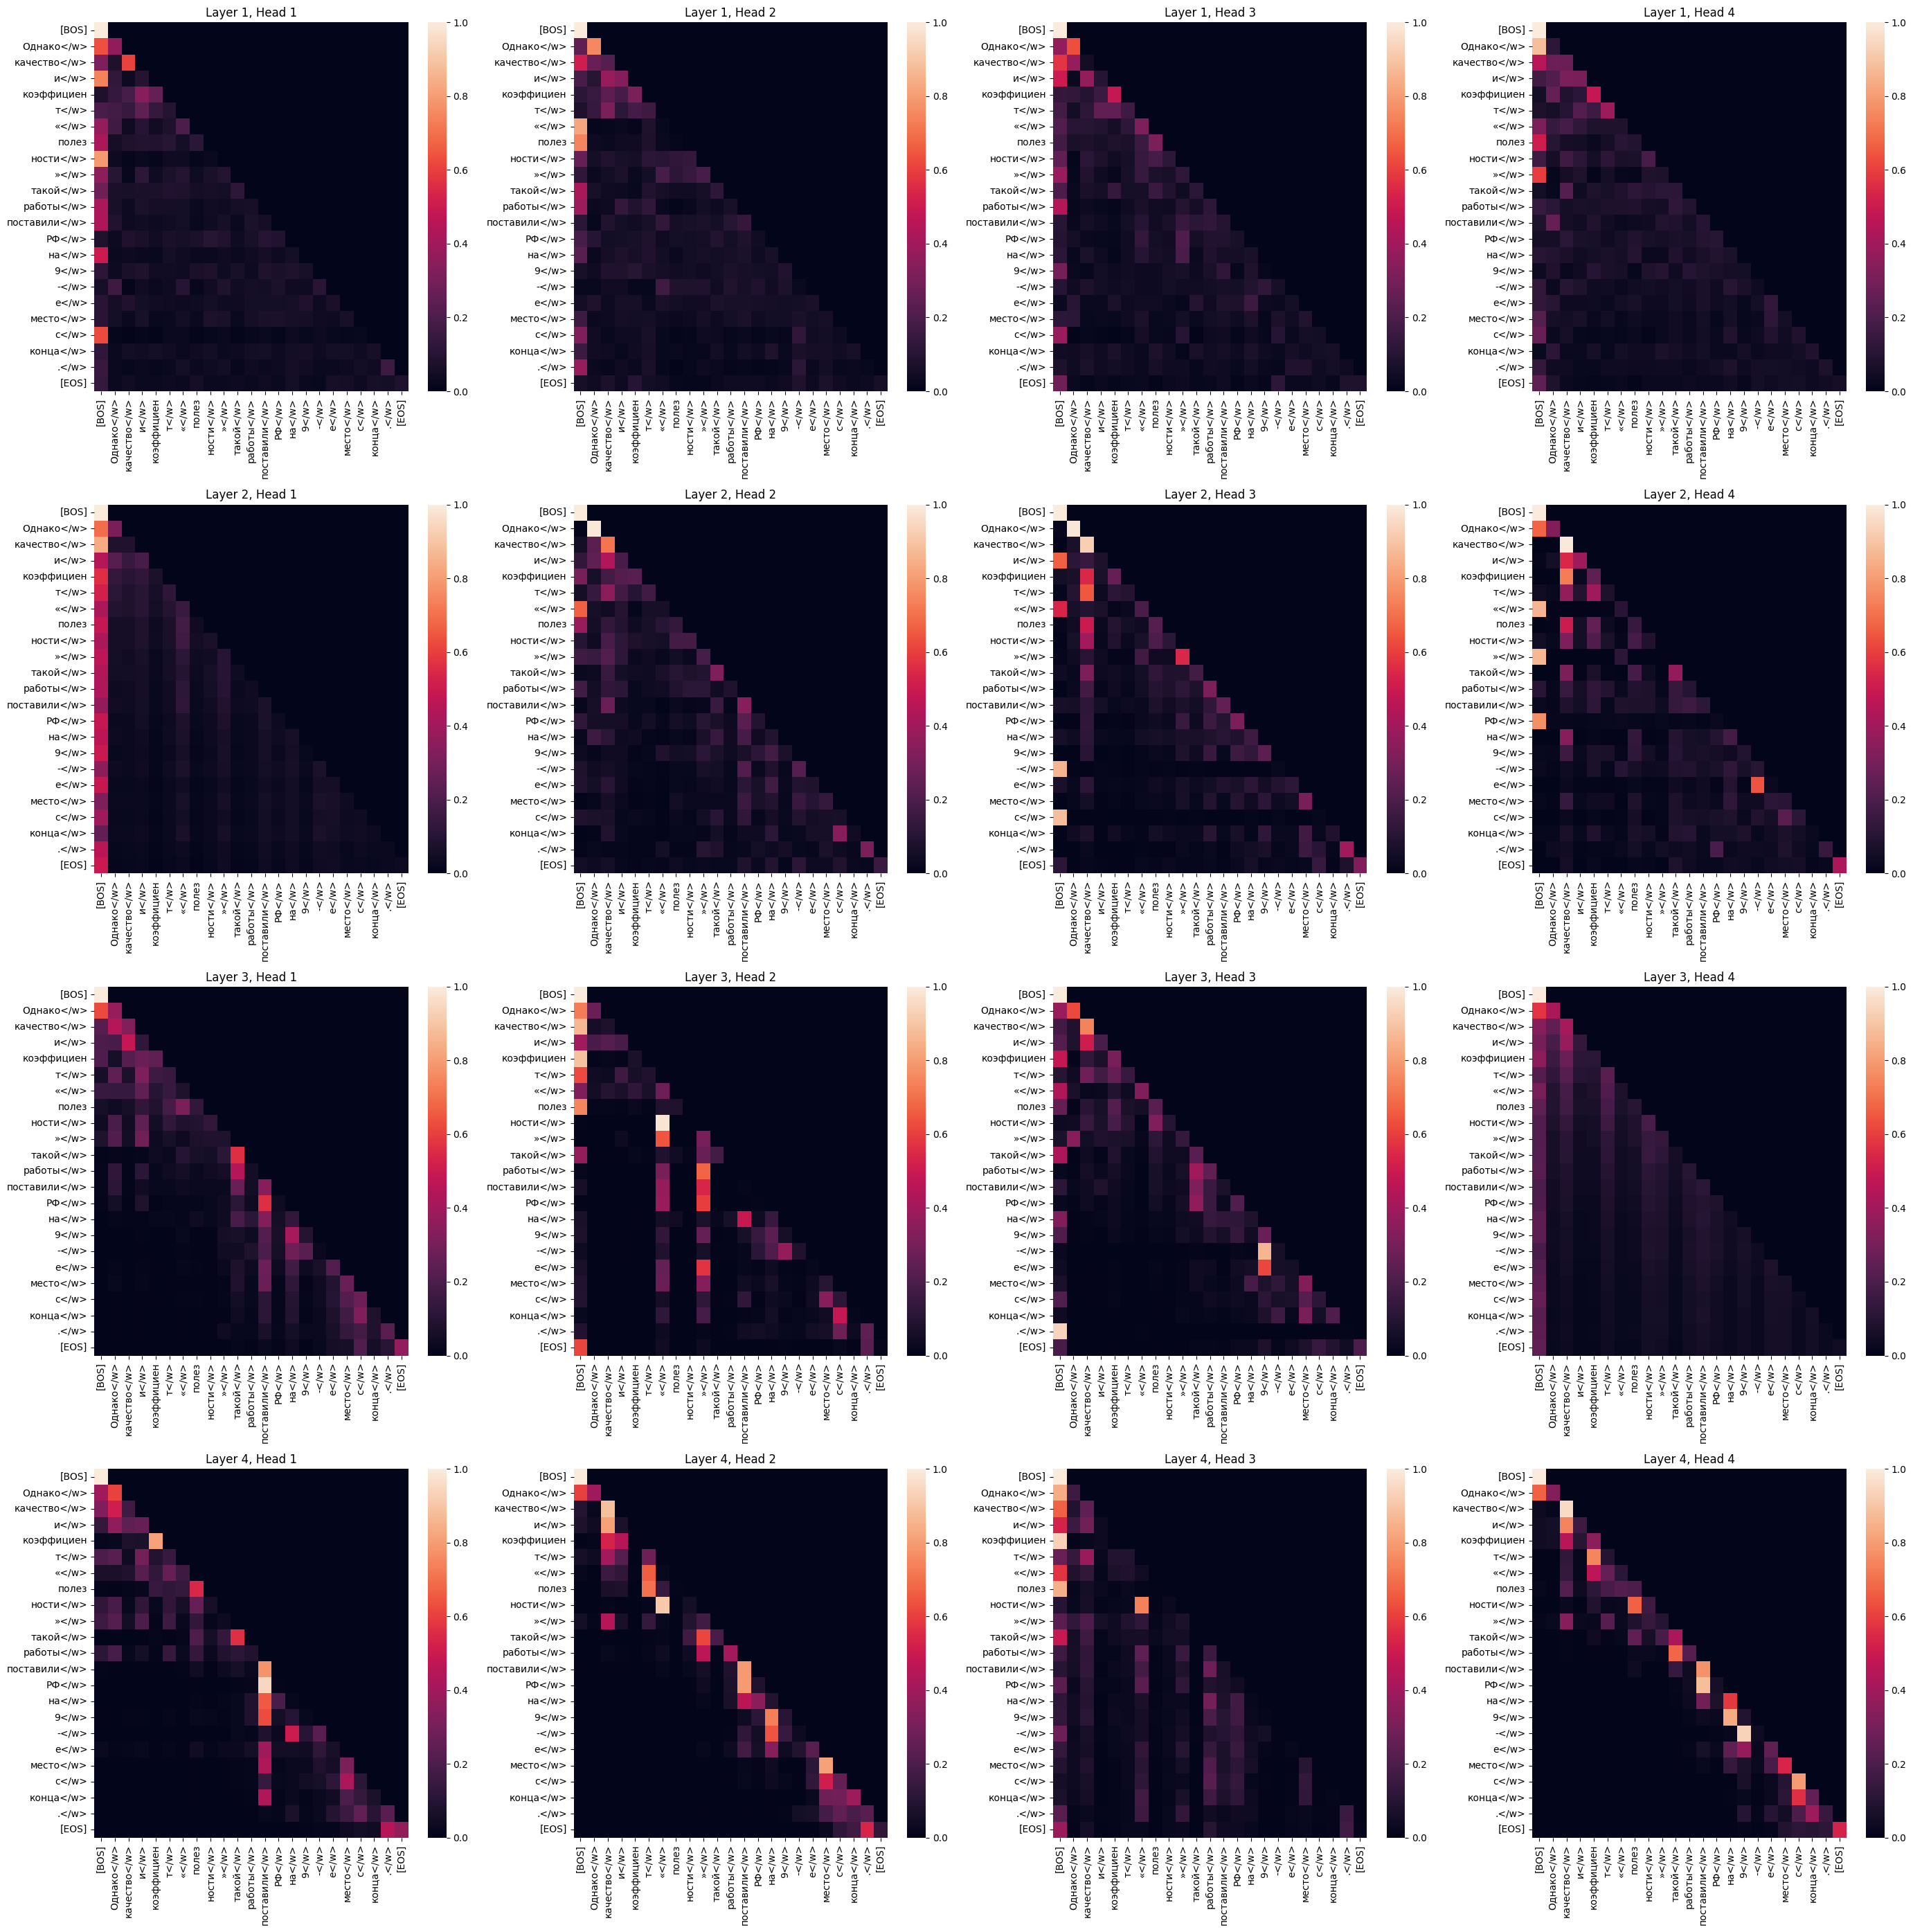

Epoch 11:


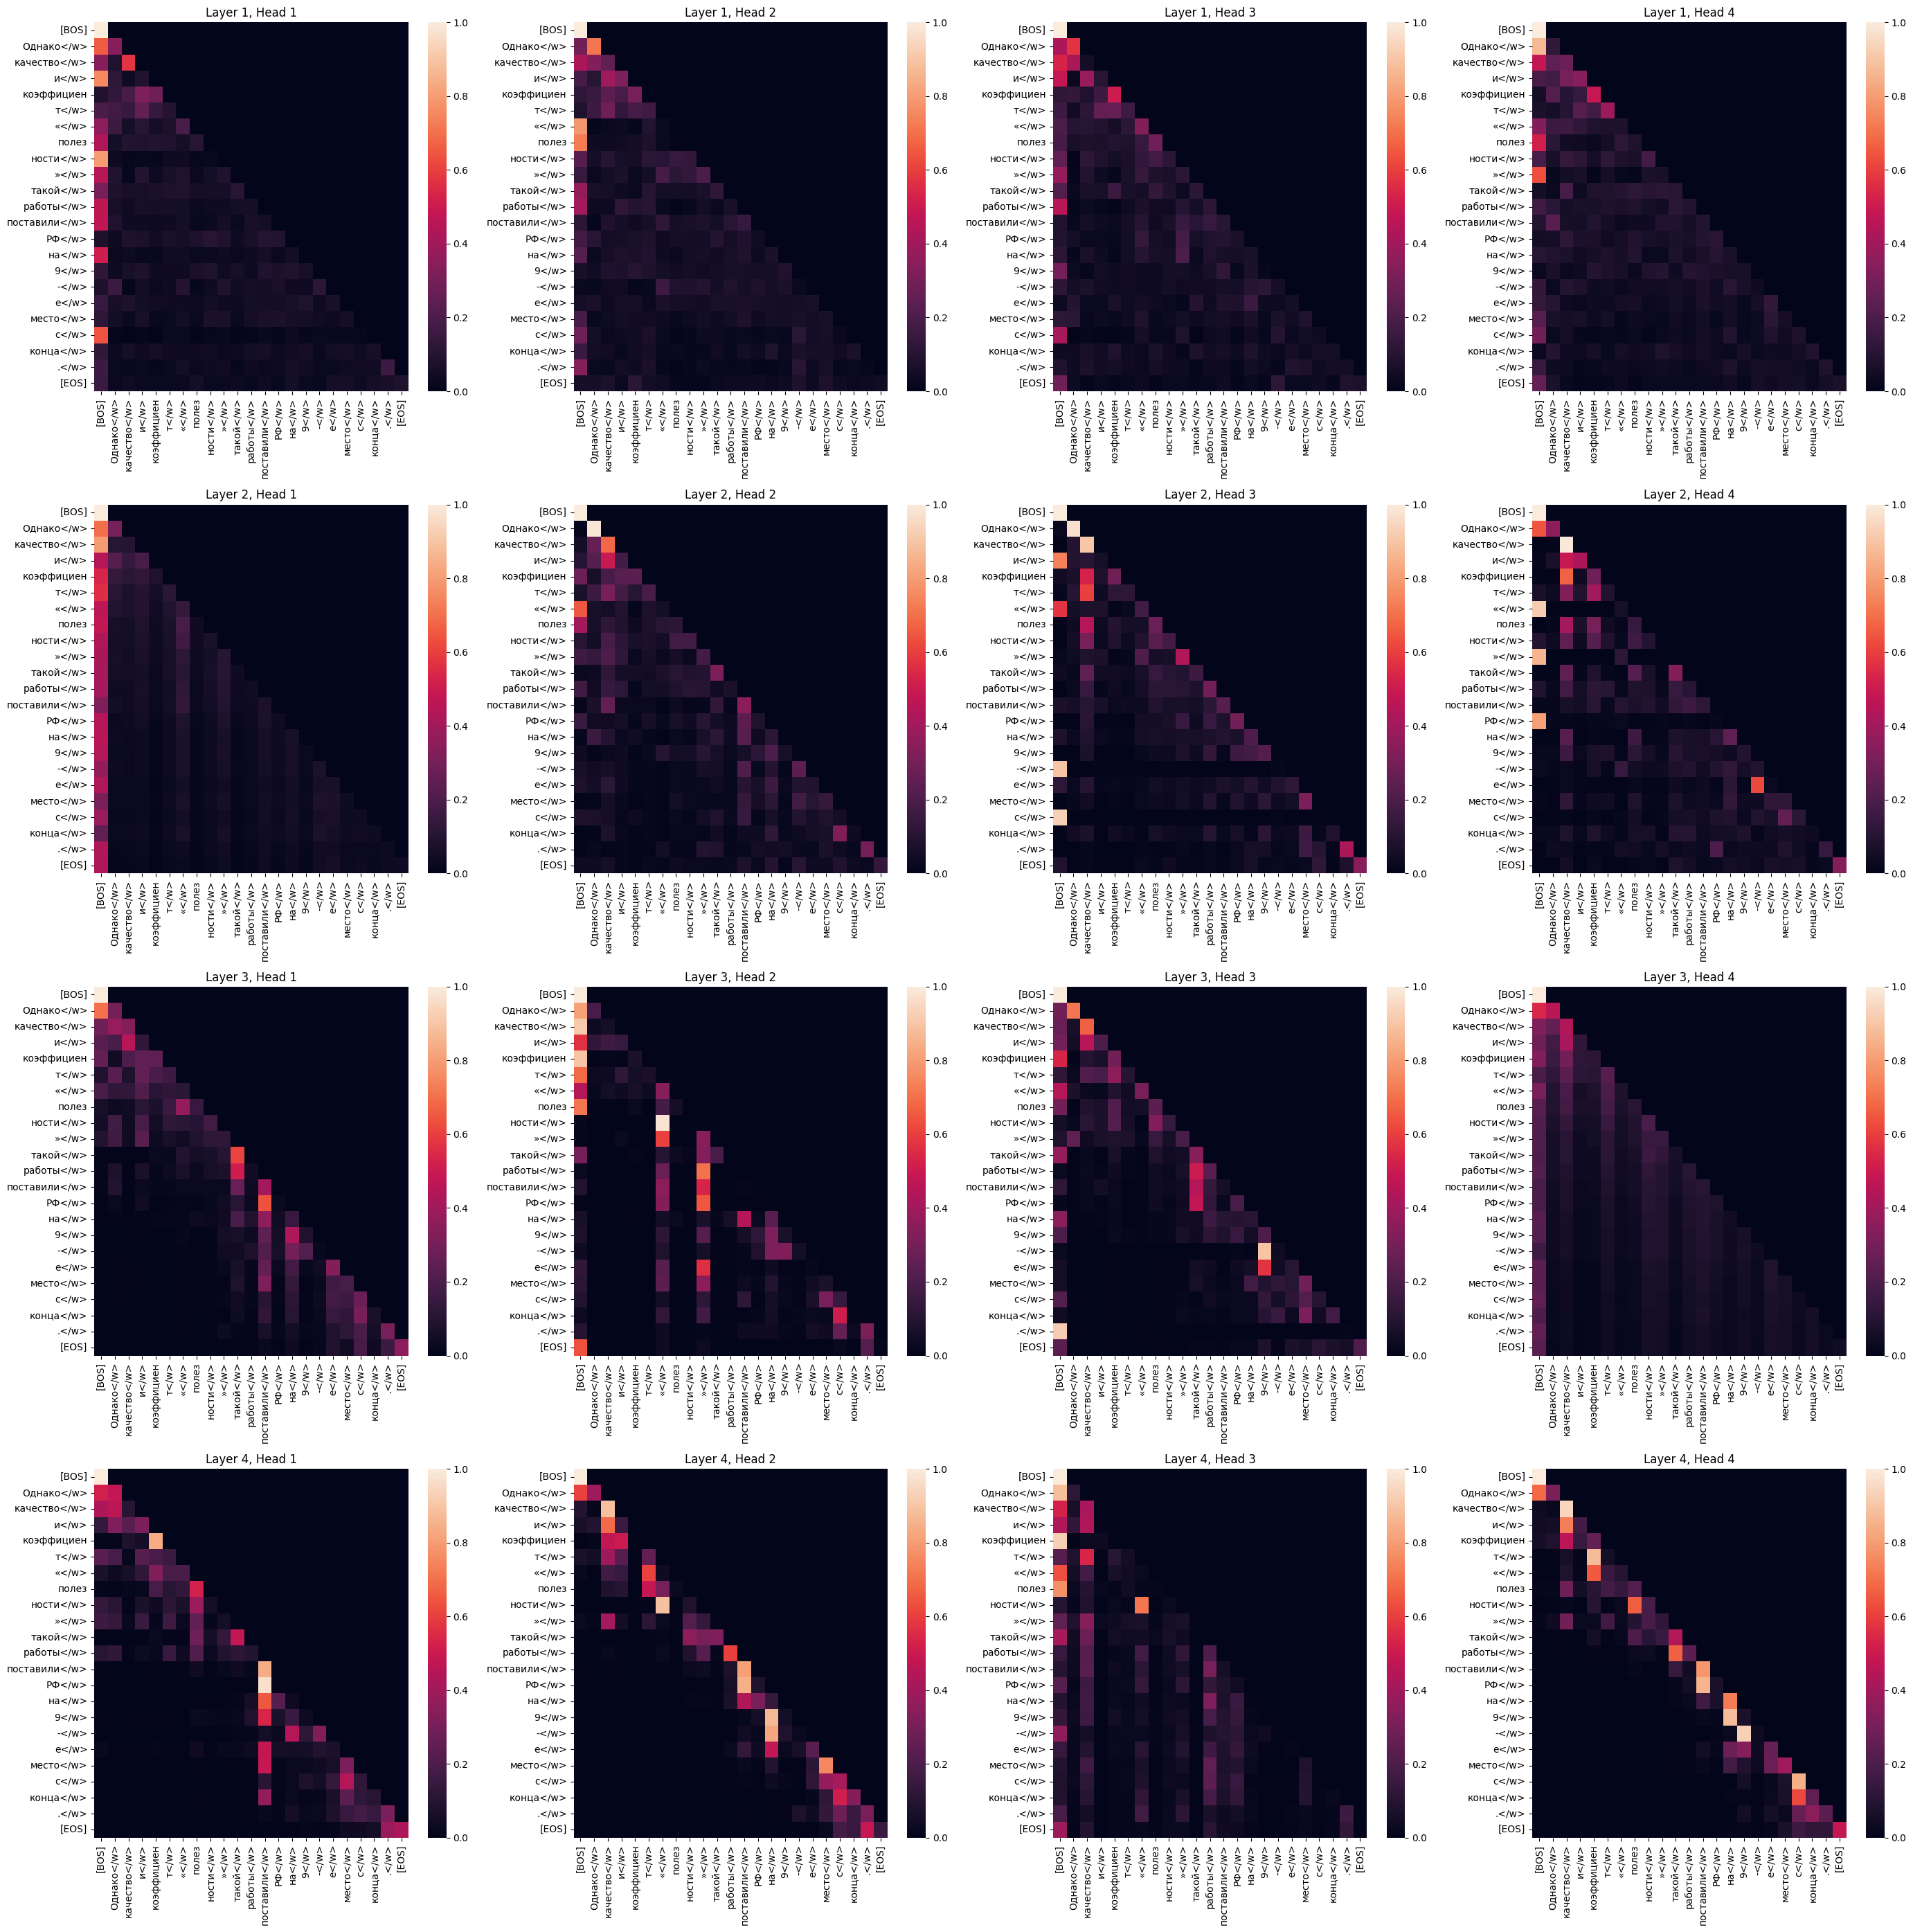

Epoch 12:


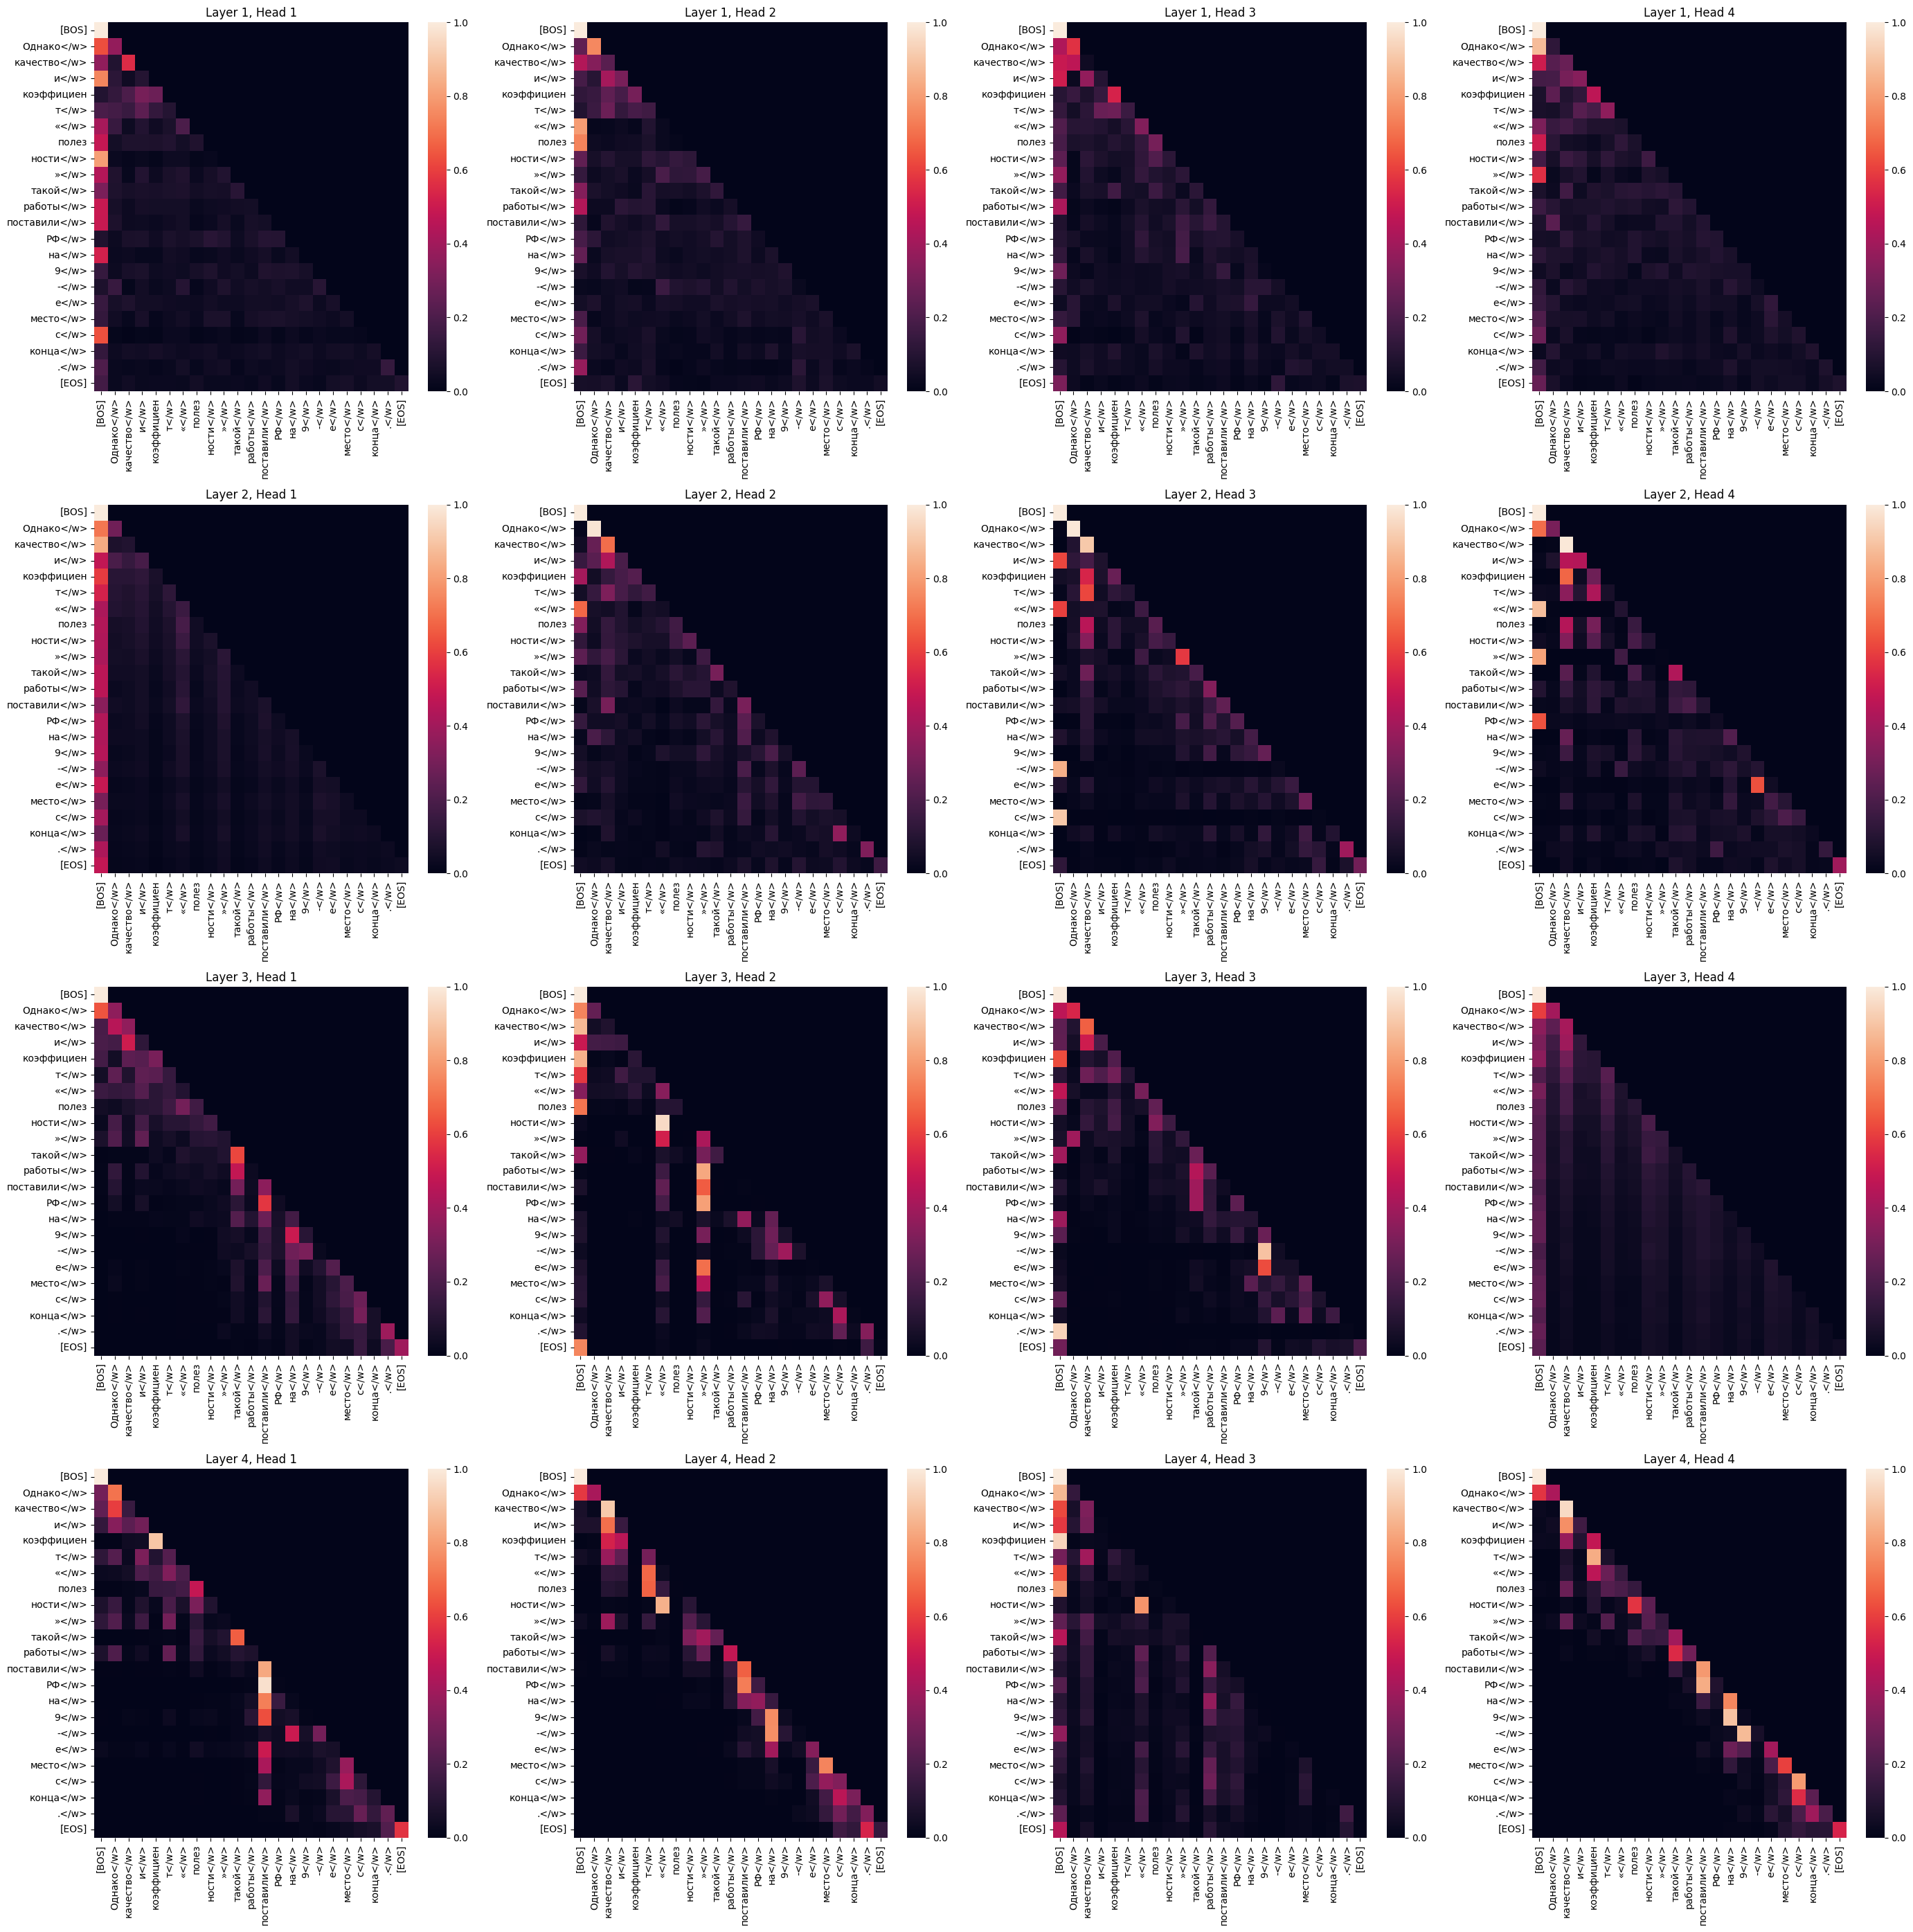

Epoch 13:


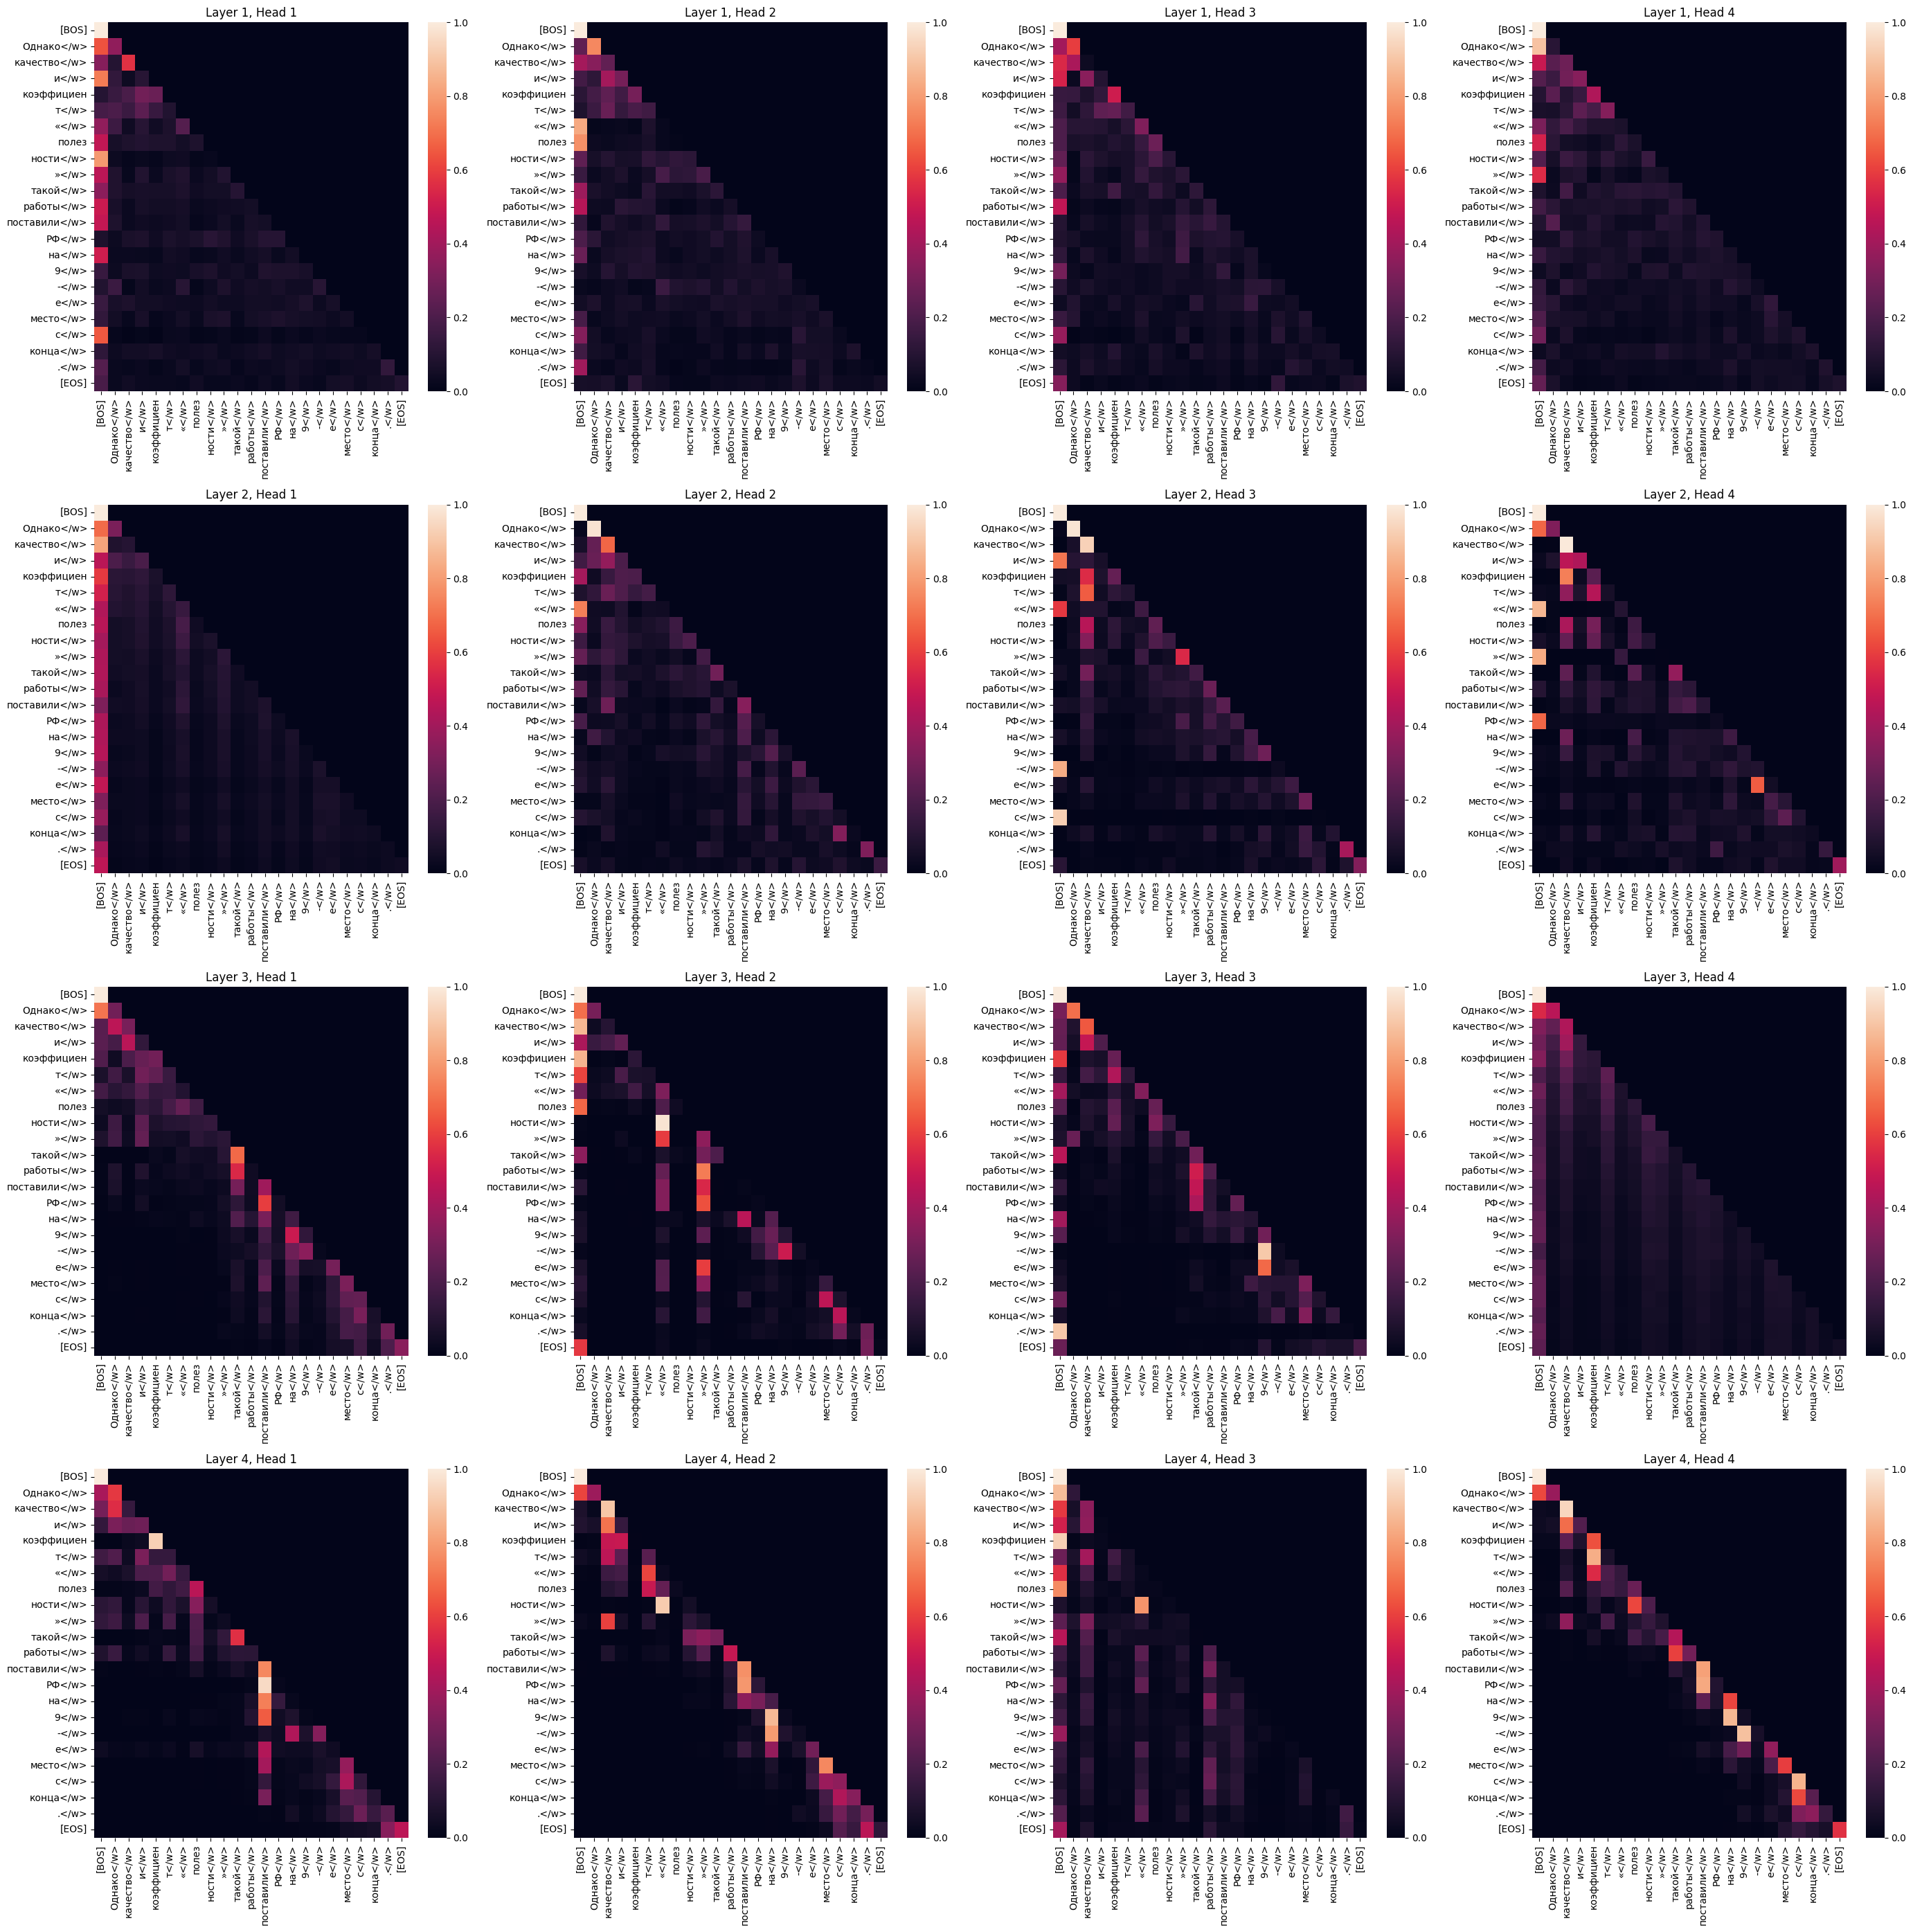

Epoch 14:


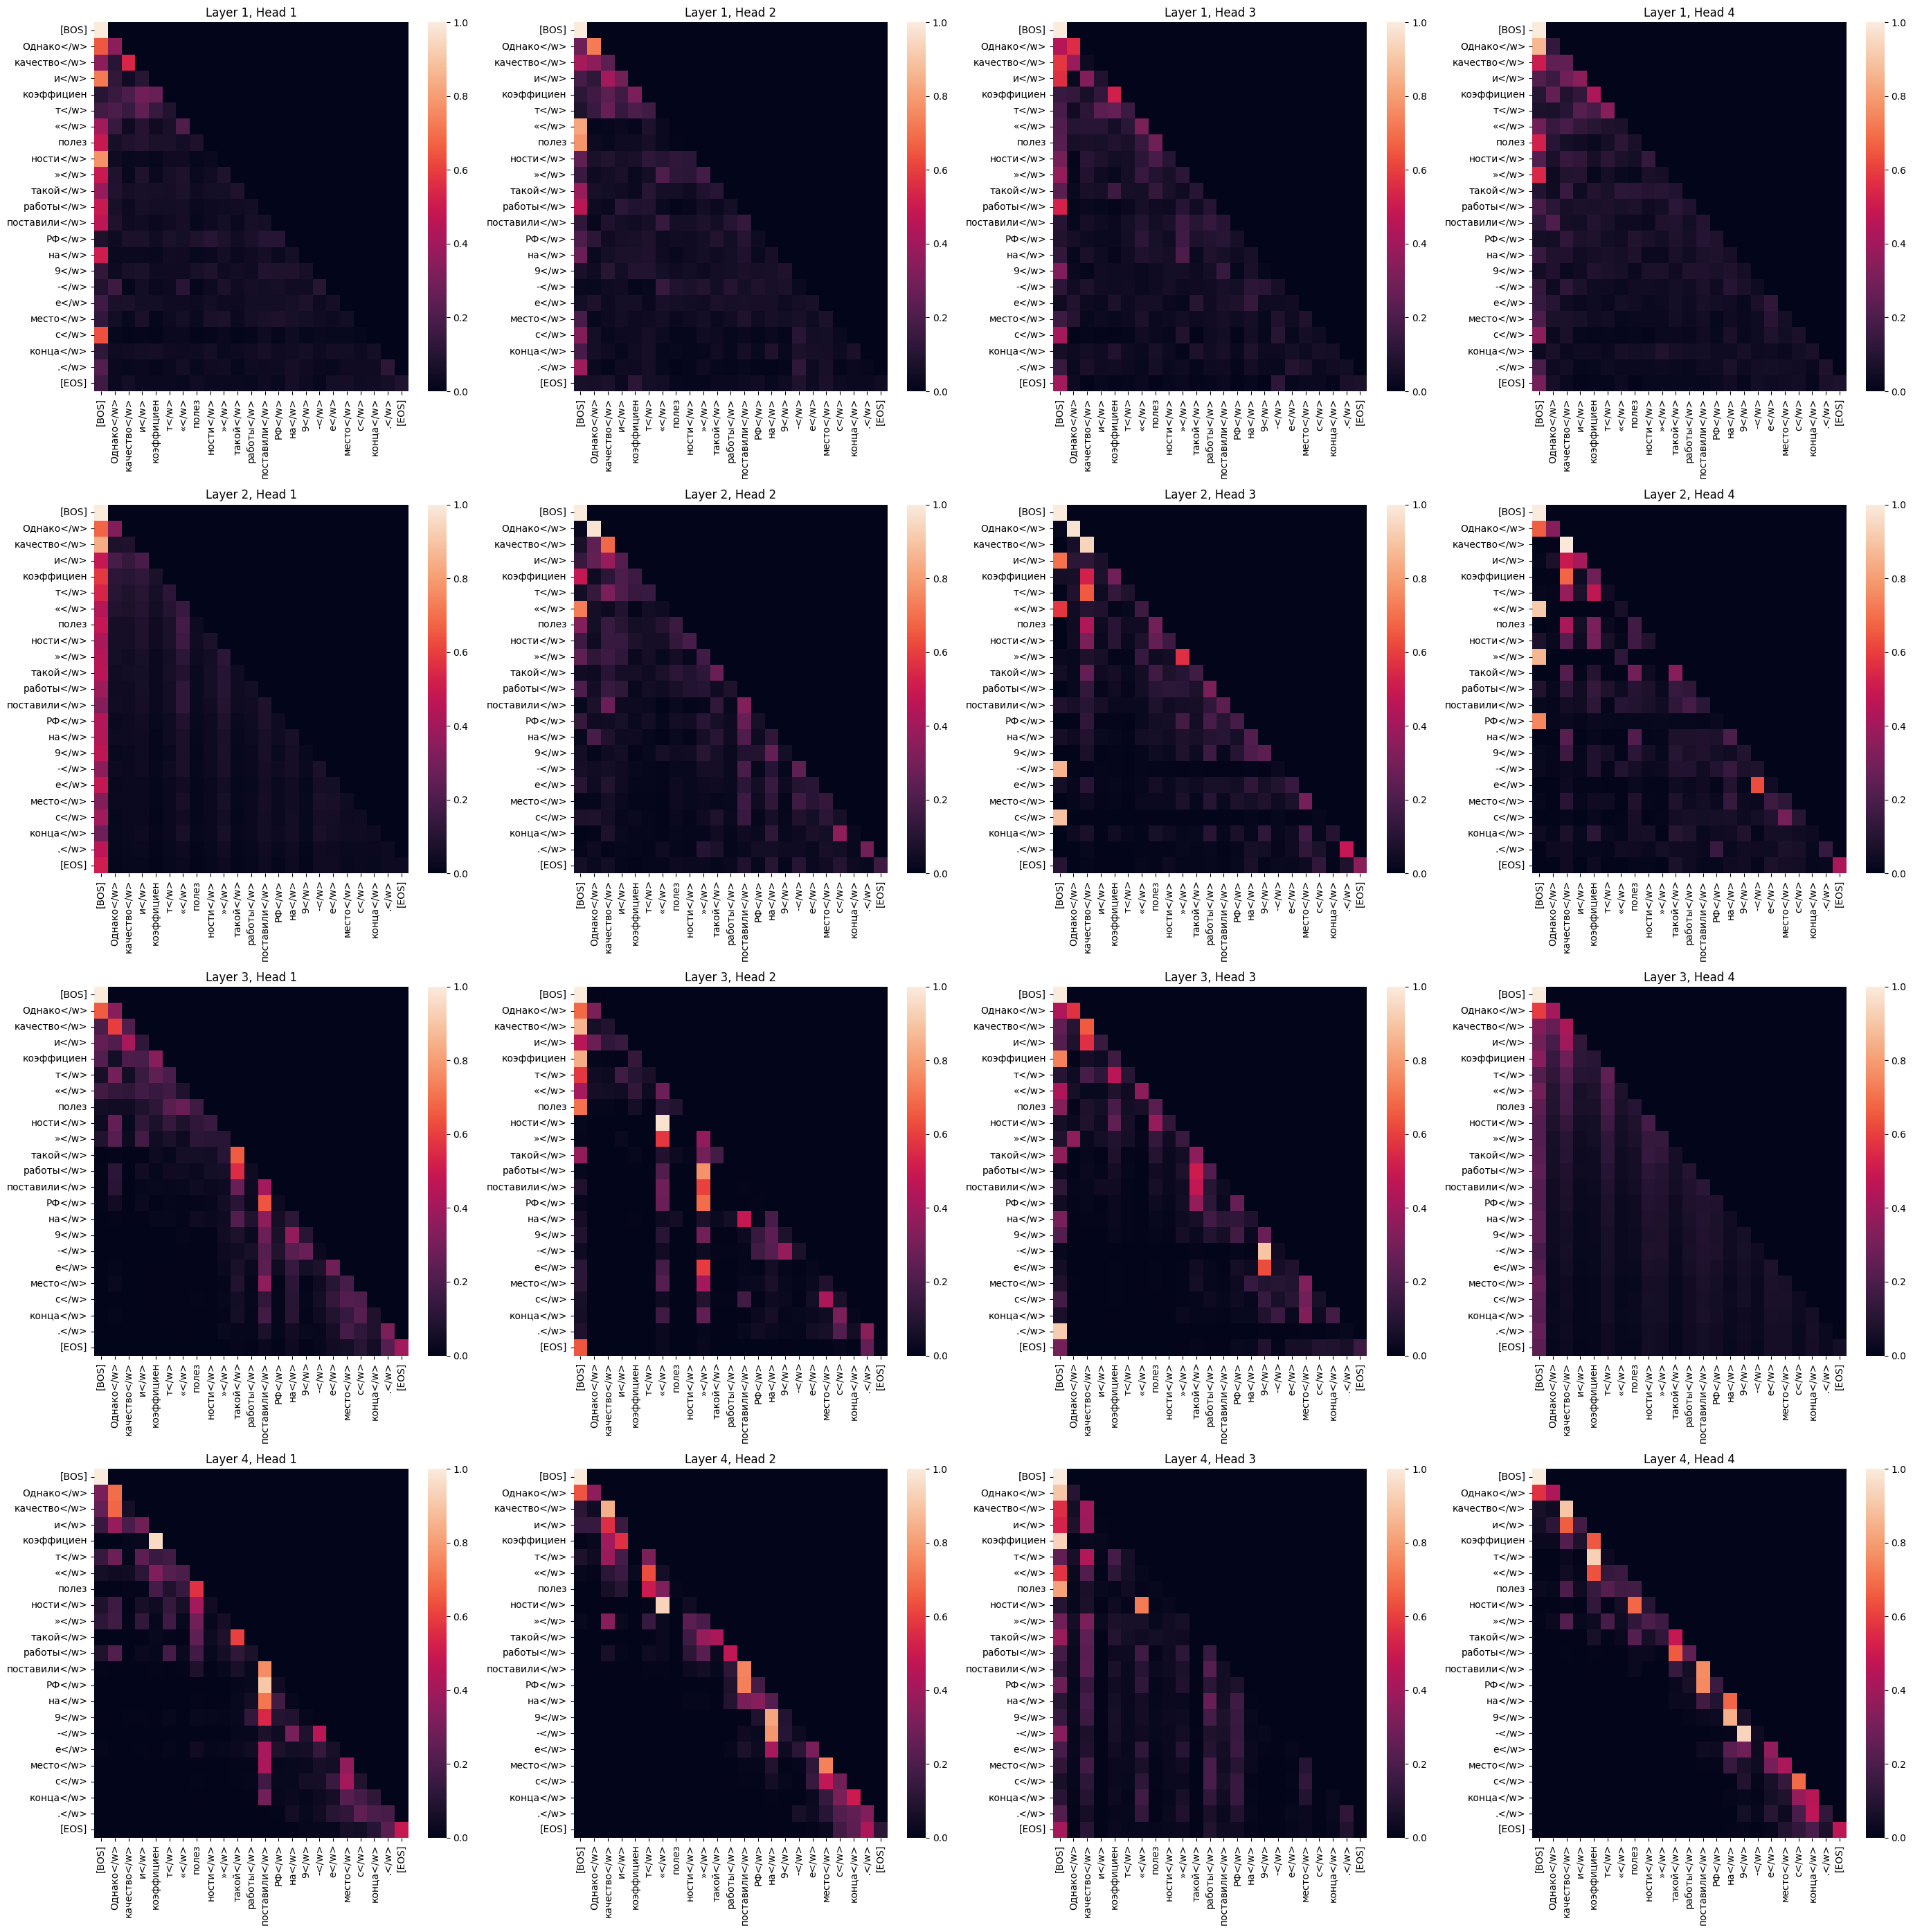

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

for epoch, attns in enumerate(all_text_attns):
    print(f"Epoch {epoch}:")
    fig, axes = plt.subplots(n_layer, n_head, figsize=(n_layer * 7, n_head * 7))
    for i in range(n_layer):
        for j in range(n_head):
            ax = axes[i, j]
            sns.heatmap(attns[i * n_head + j], ax=ax, xticklabels=tokens, yticklabels=tokens)
            ax.set_title(f"Layer {i + 1}, Head {j + 1}")
    plt.tight_layout()
    plt.show()